# Import bibliotek

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sn
import pathlib
import os
from os import listdir
import glob
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    AveragePooling2D,
    Normalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cinic_directory_train = 'D:\\GitHub\\CINIC-10\\train'
cinic_directory_test = 'D:\\GitHub\\CINIC-10\\test' 
cinic_directory_val = 'D:\\GitHub\\CINIC-10\\valid'

SEED = 1337

tf.random.set_seed(SEED)

optimiser='adamax'
nb_epochs=20
batch_size_choice=16
image_size=(32, 32)
loss_func='categorical_crossentropy'
#metrics=['categorical_accuracy','AUC','Precision','Recall',tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')] 

c:\Users\kraft\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\kraft\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

# Funkcje pomocnicze

In [2]:
def show_training_validation_loss_and_metrics(model,metrics):
    f,ax=plt.subplots(2,1,figsize=(20,20)) 

    #Assigning the first subplot to graph training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    #Plotting the training accuracy and validation accuracy
    for metric in metrics:
        ax[1].plot(model.history.history[metric],label='Training '+metric)
        ax[1].plot(model.history.history['val_'+metric],label='Validation '+metric)

    plt.legend() 

In [3]:
def create_model1(num_classes):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="relu", input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=512))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model


In [4]:
def create_model2(num_classes):
    model = Sequential()
    model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                    input_shape=(32, 32, 3)))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(LayerNormalization())
    model.add(Flatten())
    model.add(Dense(units=512))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model


In [5]:
def create_model3(num_classes):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="sigmoid", 
                    input_shape=(32, 32, 3)))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(16, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=1024))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model

In [6]:
def show_confusion_matrix(model, test_ds, num_classes, class_names):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy(), display_labels=class_names)
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

In [7]:
def show_confusion_matrix_without_names(model, test_ds, num_classes):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy())
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

# Wczytanie danych

In [13]:
# loading in the data 
train_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_train,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [14]:
# loading in the data 
validation_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_val,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [15]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_test,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [16]:
class_names= train_ds.class_names
num_classes = len(class_names)

print(class_names)

metrics=['categorical_accuracy','AUC','Precision','Recall',tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')]
metrics2 = ['categorical_accuracy','auc','precision','recall', 'f1_score']

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [17]:
# Normalize all data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [18]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    brightness_range = [0.9,1.1],
    channel_shift_range = 50
    )
datagen_valid = ImageDataGenerator(rescale=1./255)

In [19]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    cinic_directory_train,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    cinic_directory_val,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
test_it = datagen_valid.flow_from_directory(
    cinic_directory_test,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


# Architektura pierwszego modelu

In [20]:
model1 = create_model1(num_classes)

In [21]:
model1.compile( 
    loss=loss_func,
    metrics=metrics
)

In [22]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                        

In [23]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model1.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 139s 24ms/step - loss: 1.6767 - categorical_accuracy: 0.3927 - auc: 0.8352 - precision: 0.5711 - recall: 0.1881 - f1_score: 0.2634 - val_loss: 1.4571 - val_categorical_accuracy: 0.4661 - val_auc: 0.8775 - val_precision: 0.6487 - val_recall: 0.2925 - val_f1_score: 0.3469
Epoch 2/20
5625/5625 [==============================] - 136s 24ms/step - loss: 1.3776 - categorical_accuracy: 0.5030 - auc: 0.8911 - precision: 0.6808 - recall: 0.3163 - f1_score: 0.4056 - val_loss: 1.4707 - val_categorical_accuracy: 0.4895 - val_auc: 0.8831 - val_precision: 0.5958 - val_recall: 0.3627 - val_f1_score: 0.4008
Epoch 3/20
5625/5625 [==============================] - 133s 24ms/step - loss: 1.2907 - categorical_accuracy: 0.5340 - auc: 0.9048 - precision: 0.7007 - recall: 0.3642 - f1_score: 0.4566 - val_loss: 1.3279 - val_categorical_accuracy: 0.5376 - val_auc: 0.9011 - val_precision: 0.6715 - val_recall: 0.4238 - val_f1_score: 0.4752
Epoch 4/20
5625/562

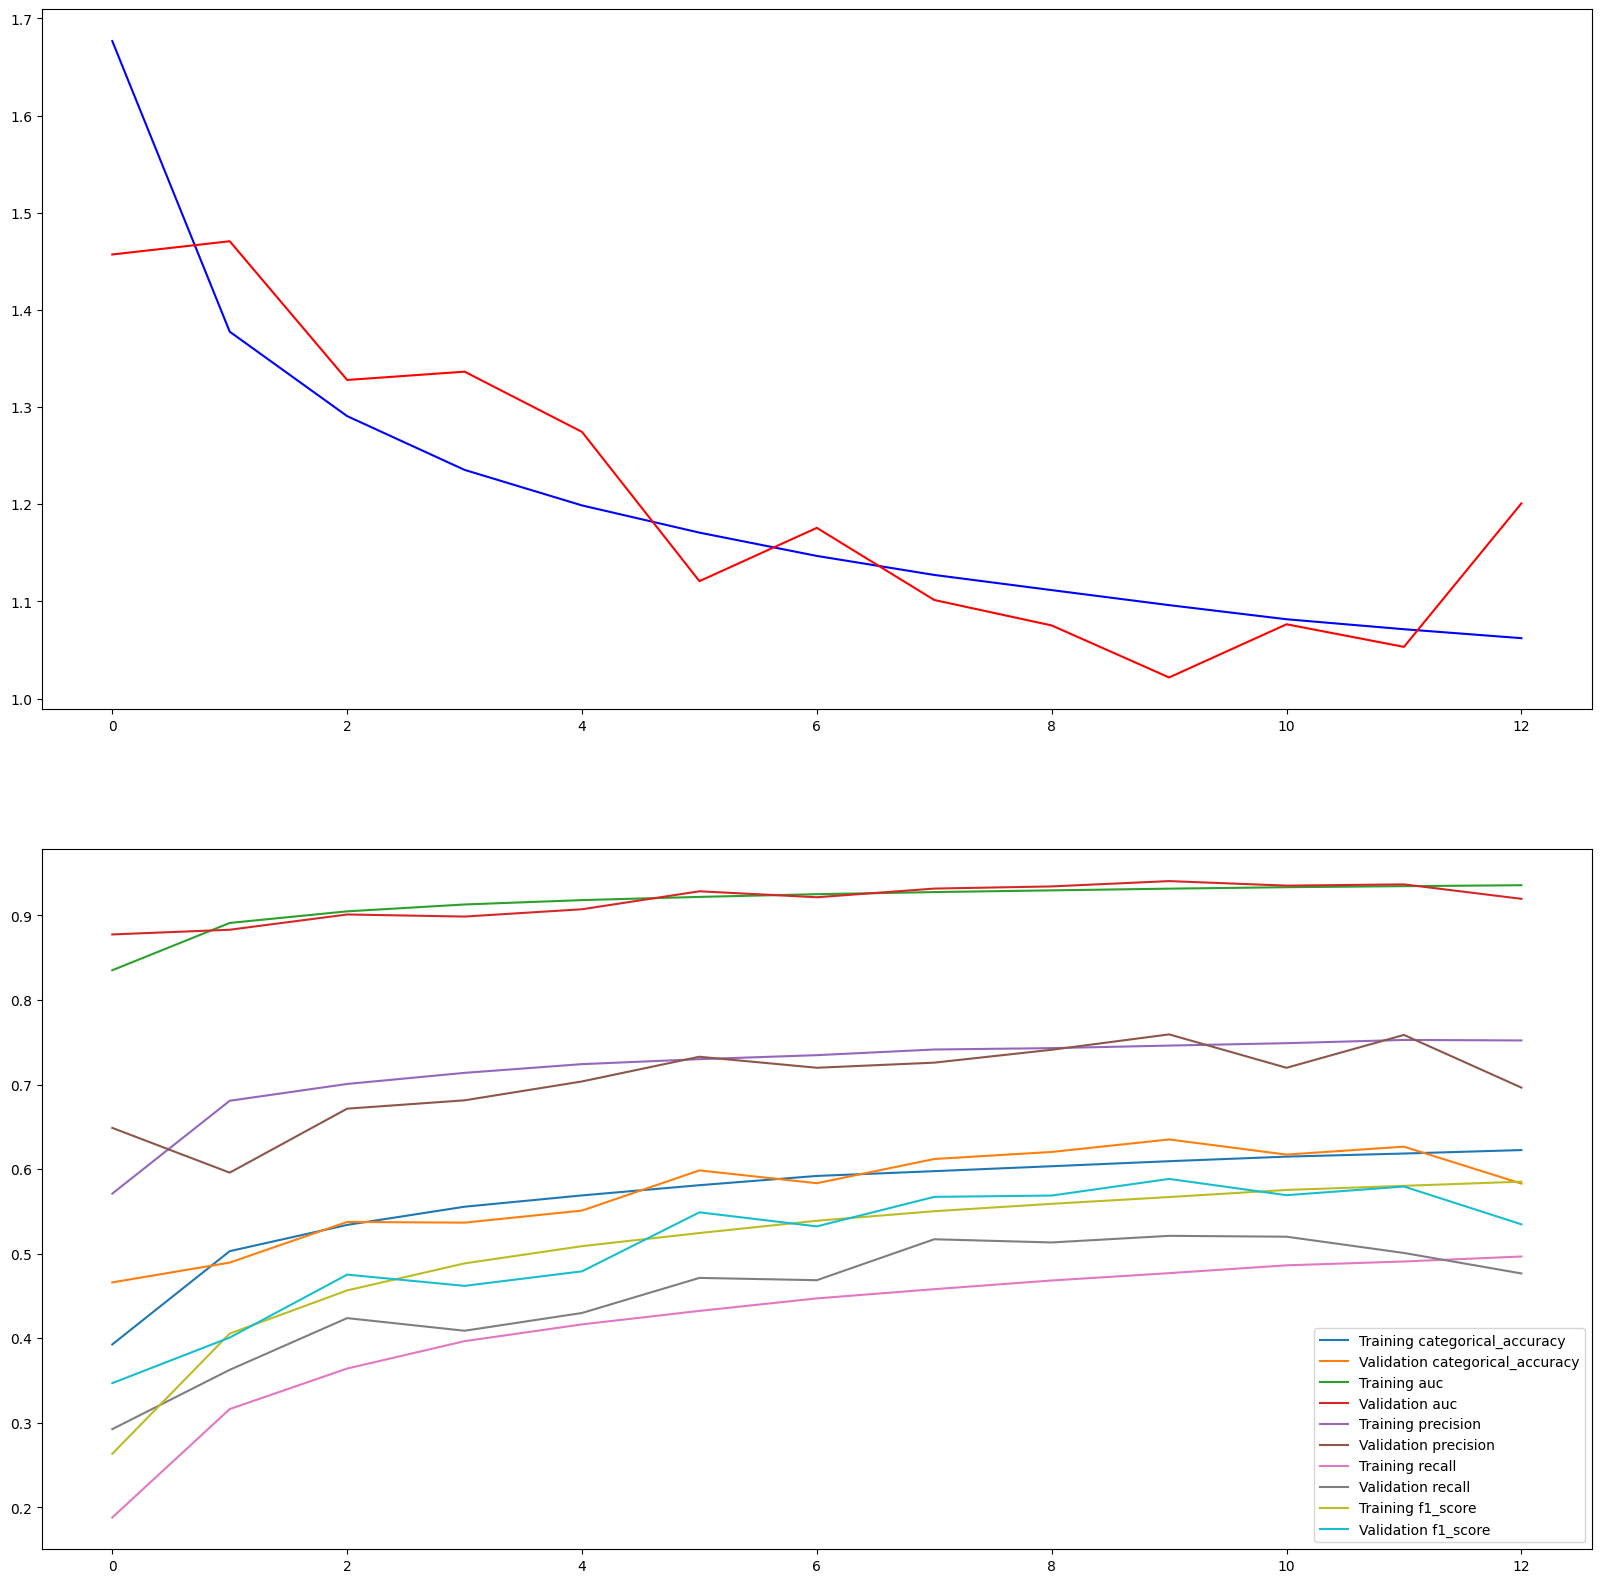

In [24]:
show_training_validation_loss_and_metrics(model1,metrics2)

In [25]:
model1.evaluate(test_it)

5625/5625 [==============================] - 47s 8ms/step - loss: 1.2062 - categorical_accuracy: 0.5823 - auc: 0.9189 - precision: 0.6976 - recall: 0.4777 - f1_score: 0.5362


[1.2061995267868042,
 0.5823333263397217,
 0.9189023375511169,
 0.6976374387741089,
 0.47771111130714417,
 0.5361859798431396]

5625/5625 [==============================] - 22s 4ms/step


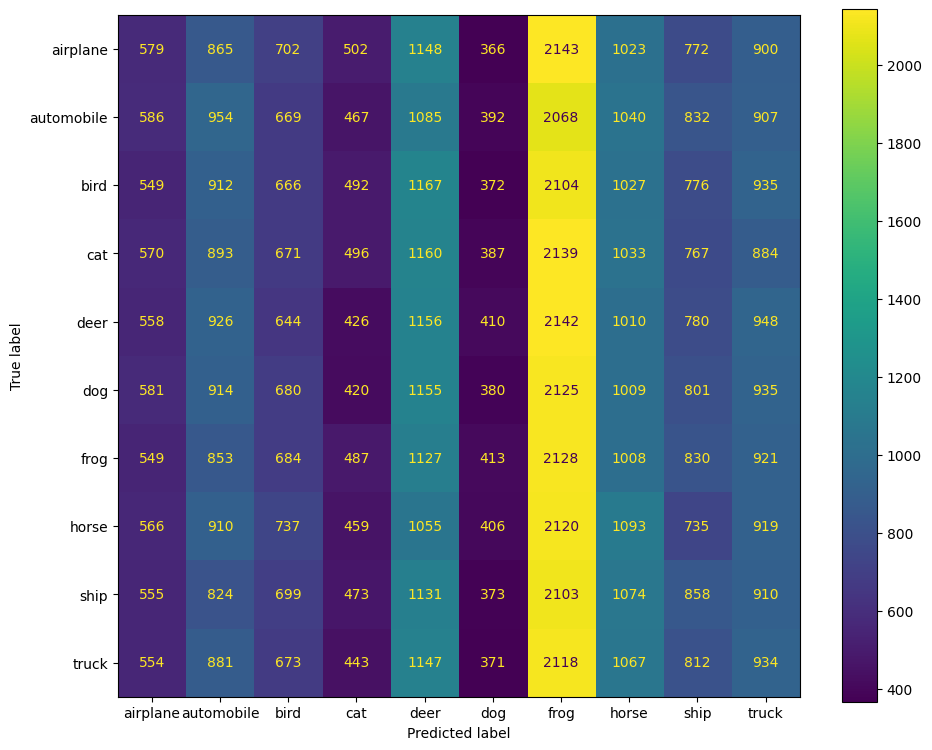

In [27]:
show_confusion_matrix(model1,test_ds,num_classes,class_names)

5625/5625 [==============================] - 24s 4ms/step


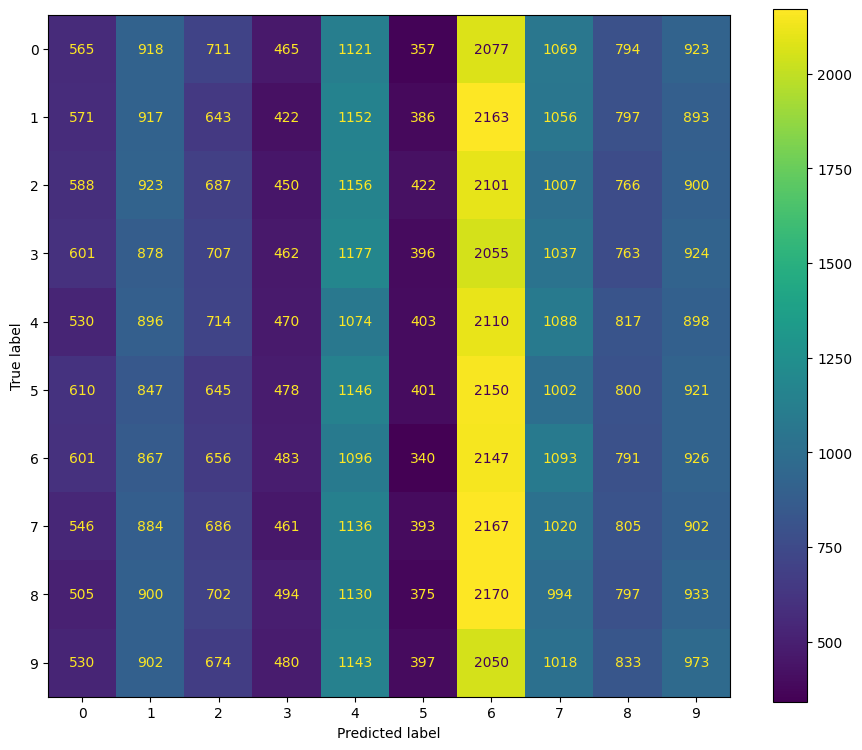

In [28]:
show_confusion_matrix_without_names(model1,test_ds,num_classes)

# Architektura drugiego modelu

In [29]:
model2 = create_model2(num_classes)

In [30]:
model2.compile( 
    loss=loss_func,
    metrics=metrics
)

In [31]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization (LayerN  (None, 32, 32, 75)       150       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 75)       0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_1 (Laye  (None, 16, 16, 50)       100       
 rNormalization)                                                 
                                                      

In [32]:
history = model2.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20


5625/5625 [==============================] - 141s 25ms/step - loss: 1.8120 - categorical_accuracy: 0.3420 - auc: 0.8007 - precision: 0.5673 - recall: 0.1055 - f1_score: 0.3830 - val_loss: 1.5613 - val_categorical_accuracy: 0.4294 - val_auc: 0.8580 - val_precision: 0.6312 - val_recall: 0.2308 - val_f1_score: 0.2984
Epoch 2/20
5625/5625 [==============================] - 140s 25ms/step - loss: 1.5510 - categorical_accuracy: 0.4326 - auc: 0.8593 - precision: 0.6490 - recall: 0.2033 - f1_score: 0.2823 - val_loss: 1.4116 - val_categorical_accuracy: 0.4786 - val_auc: 0.8855 - val_precision: 0.6650 - val_recall: 0.3060 - val_f1_score: 0.3701
Epoch 3/20
5625/5625 [==============================] - 142s 25ms/step - loss: 1.4592 - categorical_accuracy: 0.4687 - auc: 0.8767 - precision: 0.6714 - recall: 0.2534 - f1_score: 0.3376 - val_loss: 1.4157 - val_categorical_accuracy: 0.4919 - val_auc: 0.8847 - val_precision: 0.6702 - val_recall: 0.3078 - val_f1_score: 0.3780
Epoch 4/20
5625/5625 [========

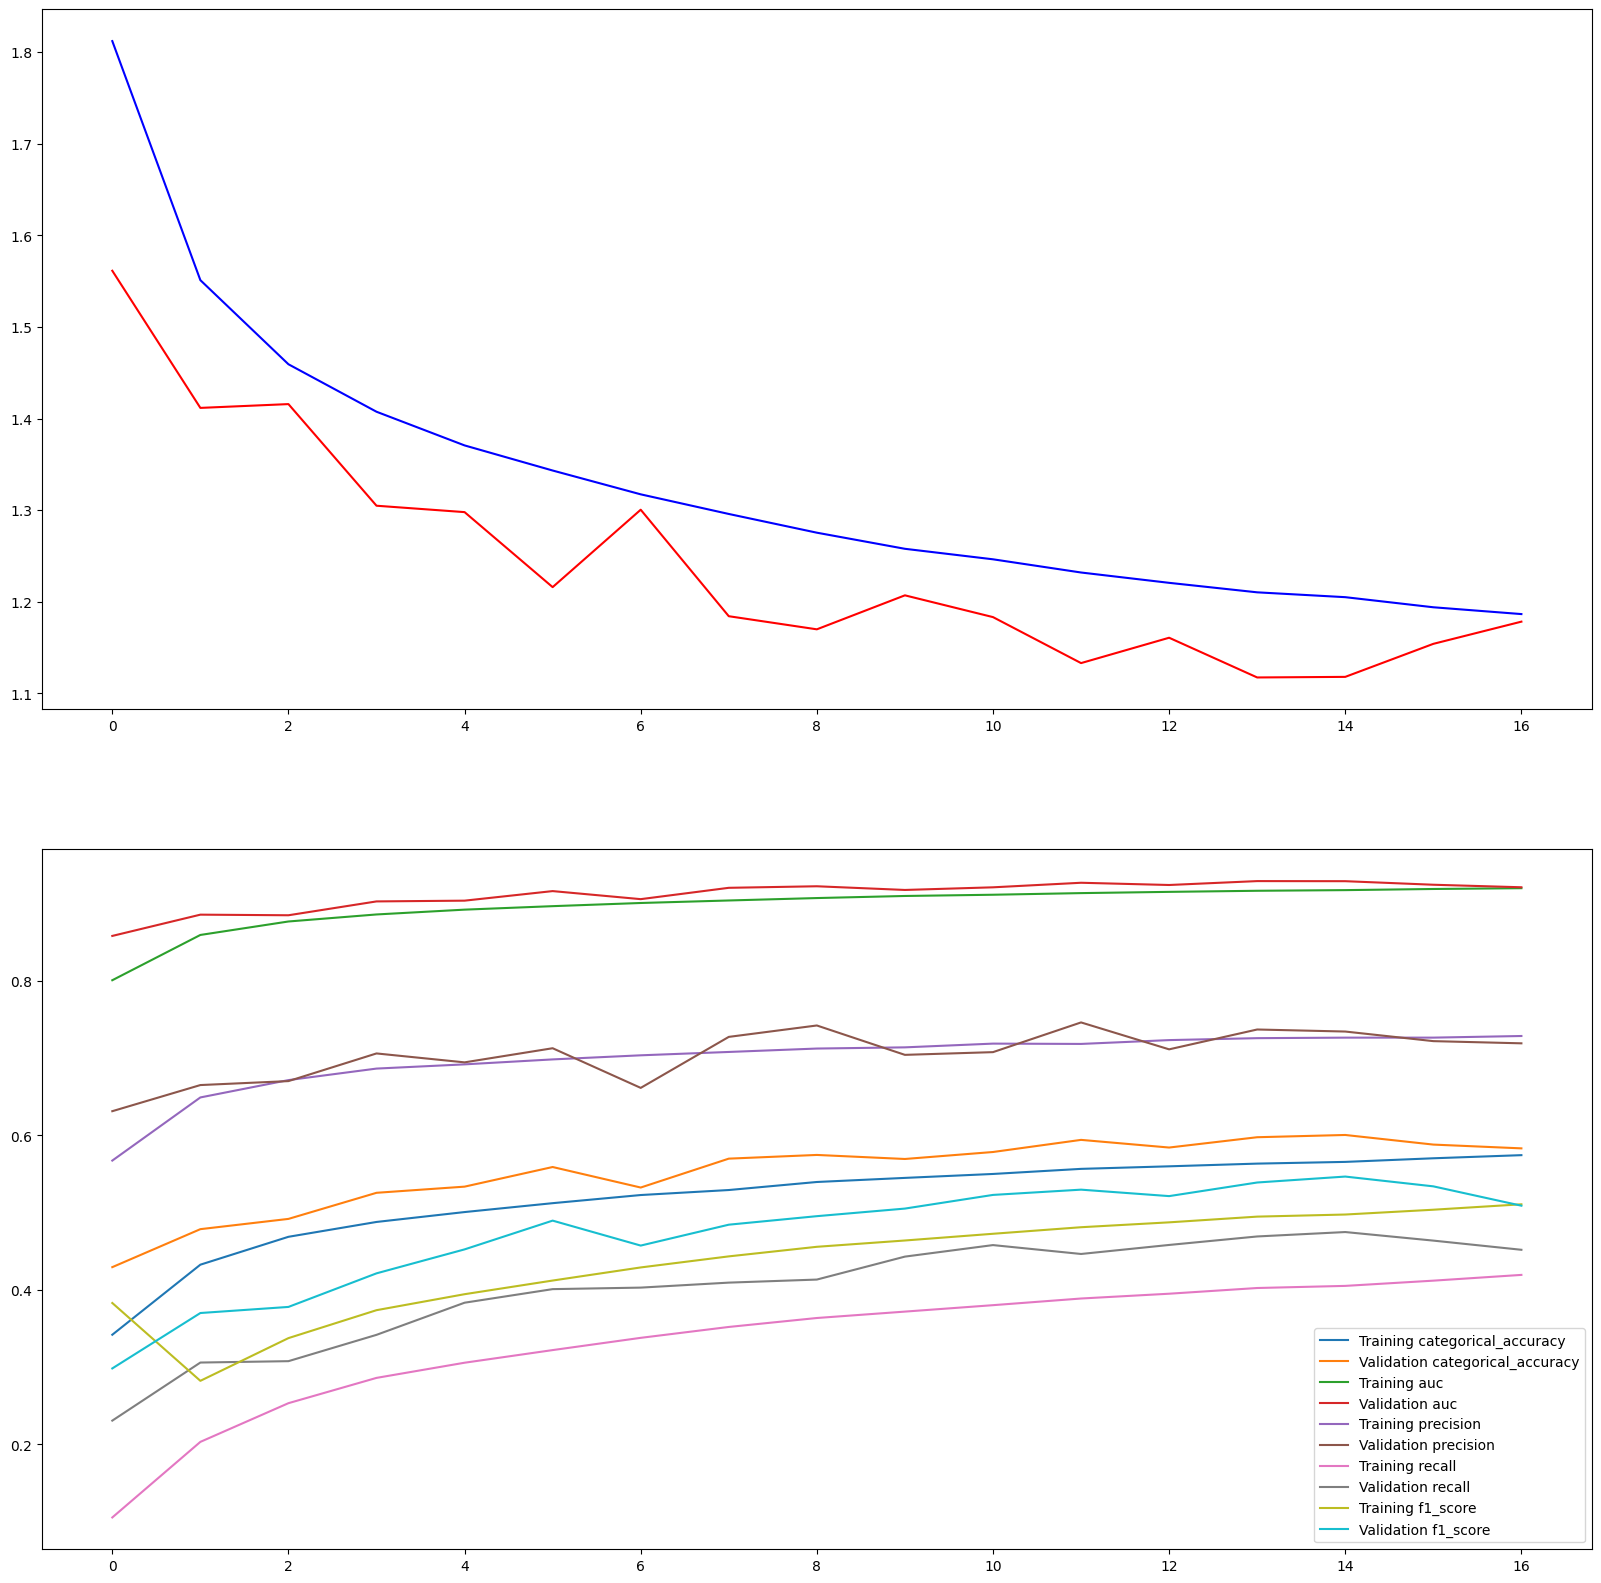

In [33]:
show_training_validation_loss_and_metrics(model2,metrics2)

In [34]:
model2.evaluate(test_it)

5625/5625 [==============================] - 45s 8ms/step - loss: 1.1861 - categorical_accuracy: 0.5820 - auc: 0.9199 - precision: 0.7161 - recall: 0.4497 - f1_score: 0.5067


[1.1860756874084473,
 0.5819555521011353,
 0.9199414253234863,
 0.7161107659339905,
 0.4496777653694153,
 0.5066704750061035]

5625/5625 [==============================] - 20s 3ms/step


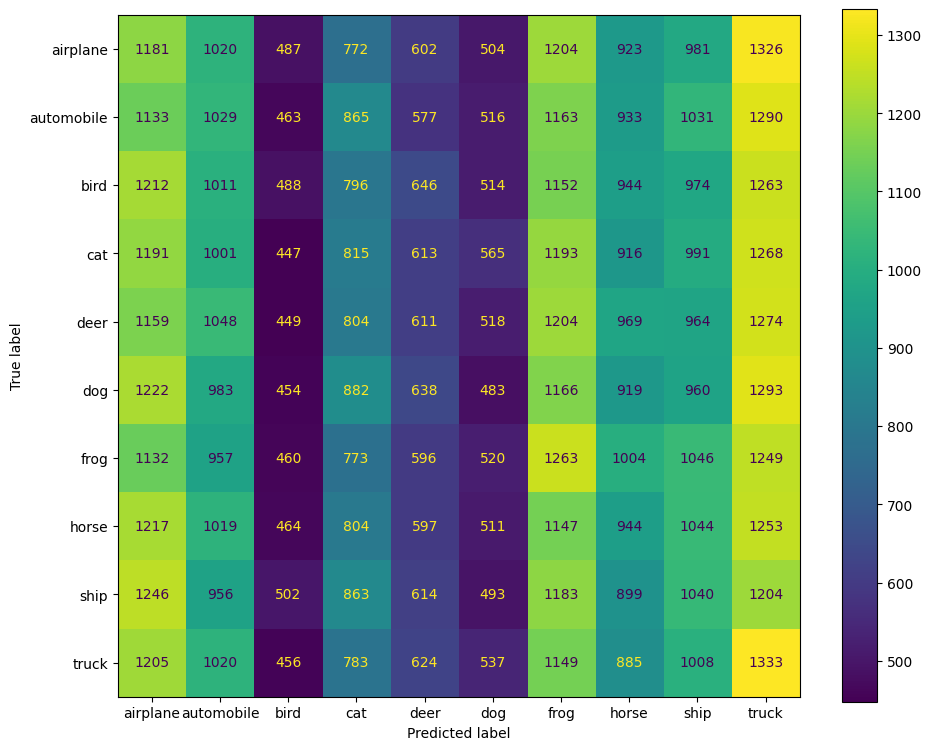

In [35]:
show_confusion_matrix(model2,test_ds,num_classes,class_names)

5625/5625 [==============================] - 19s 3ms/step


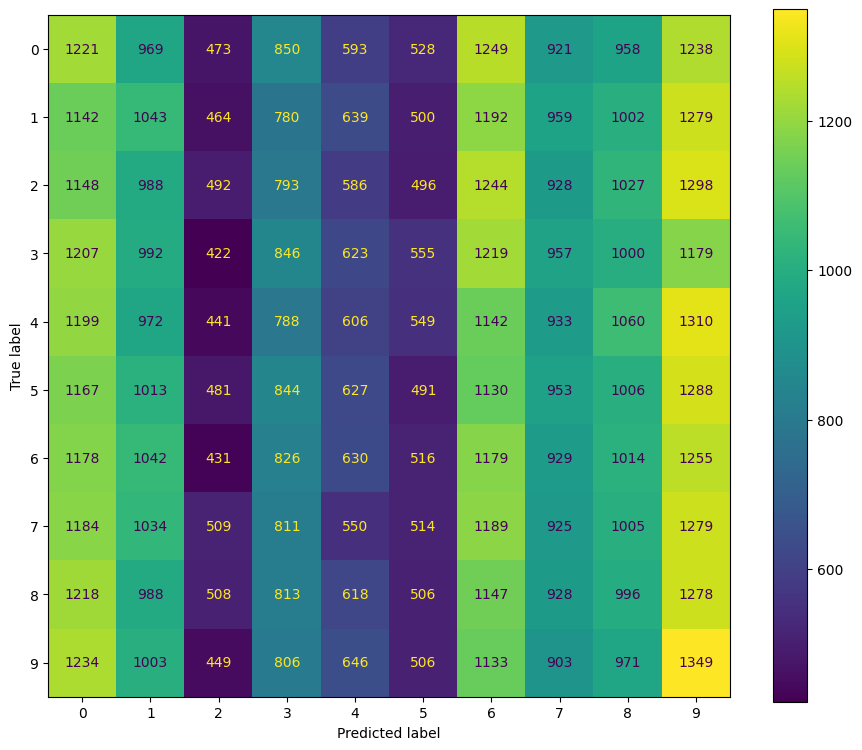

In [36]:
show_confusion_matrix_without_names(model2,test_ds,num_classes)

# Architektura trzeciego modelu

In [37]:
model3 = create_model3(num_classes)

In [38]:
model3.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [39]:
history = model3.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 138s 24ms/step - loss: 1.7484 - categorical_accuracy: 0.3428 - auc: 0.8136 - precision: 0.6014 - recall: 0.0979 - f1_score: 0.3606 - val_loss: 1.5269 - val_categorical_accuracy: 0.4230 - val_auc: 0.8653 - val_precision: 0.6047 - val_recall: 0.2197 - val_f1_score: 0.2642
Epoch 2/20
5625/5625 [==============================] - 137s 24ms/step - loss: 1.5172 - categorical_accuracy: 0.4382 - auc: 0.8659 - precision: 0.6538 - recall: 0.2139 - f1_score: 0.2876 - val_loss: 1.3884 - val_categorical_accuracy: 0.4865 - val_auc: 0.8895 - val_precision: 0.6653 - val_recall: 0.3020 - val_f1_score: 0.3522
Epoch 3/20
5625/5625 [==============================] - 136s 24ms/step - loss: 1.4220 - categorical_accuracy: 0.4761 - auc: 0.8835 - precision: 0.6775 - recall: 0.2705 - f1_score: 0.3497 - val_loss: 1.3738 - val_categorical_accuracy: 0.4951 - val_auc: 0.8927 - val_precision: 0.6464 - val_recall: 0.3430 - val_f1_score: 0.3821
Epoch 4/20
5625/562

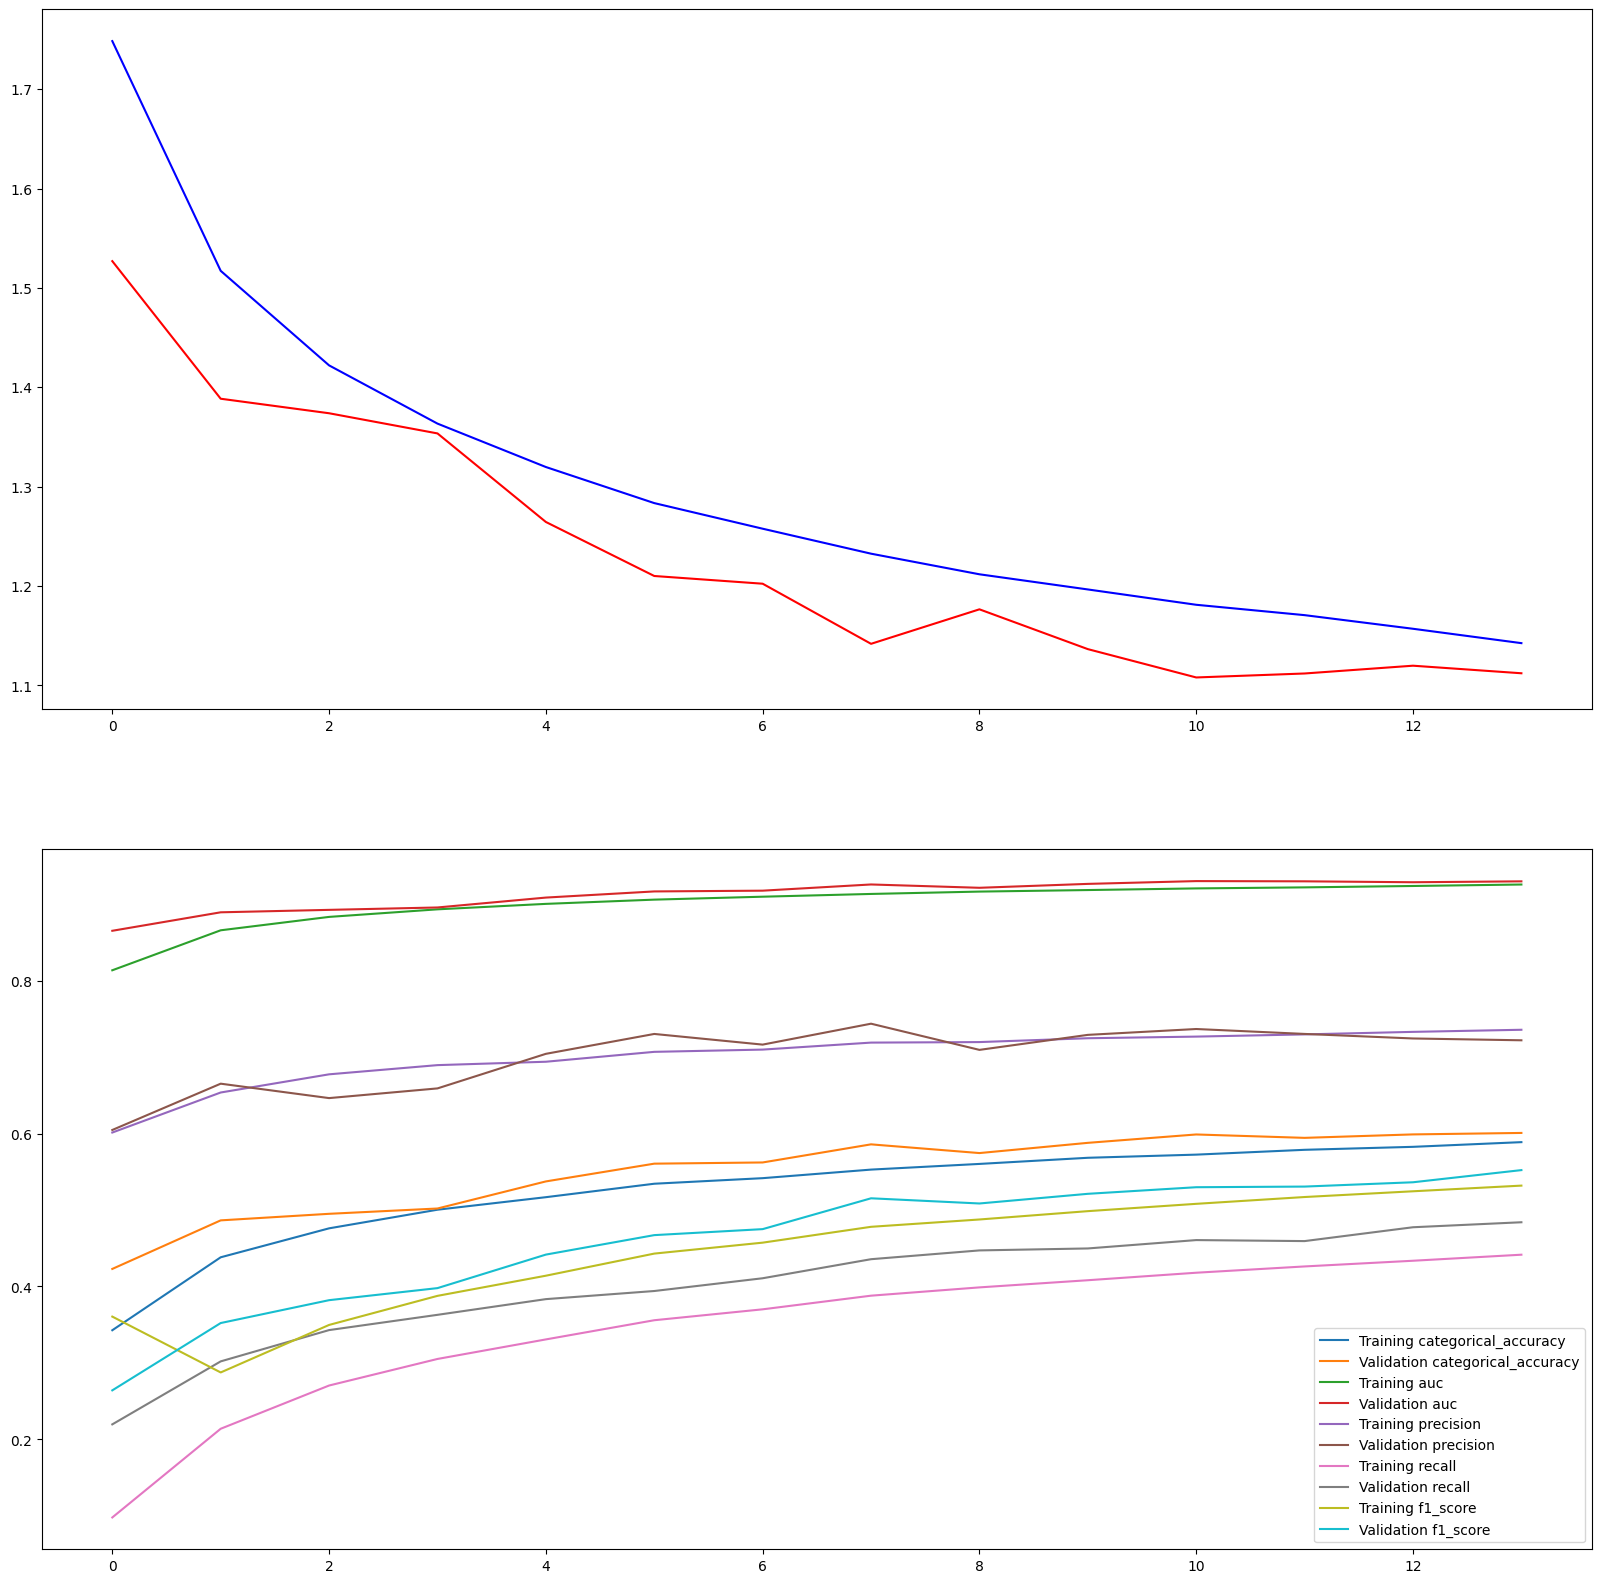

In [40]:
show_training_validation_loss_and_metrics(model3,metrics2)

In [41]:
model3.evaluate(test_it)

5625/5625 [==============================] - 44s 8ms/step - loss: 1.1164 - categorical_accuracy: 0.6004 - auc: 0.9294 - precision: 0.7237 - recall: 0.4848 - f1_score: 0.5544


[1.1163700819015503,
 0.6003888845443726,
 0.9293912649154663,
 0.7237352728843689,
 0.48482221364974976,
 0.5544185042381287]

5625/5625 [==============================] - 22s 4ms/step


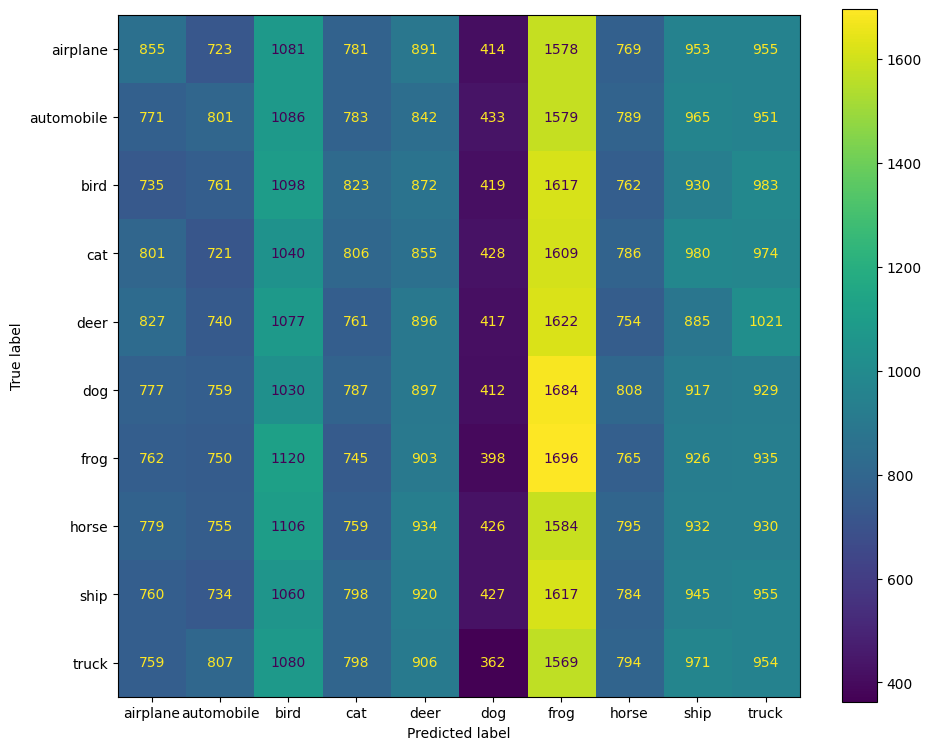

In [42]:
show_confusion_matrix(model3,test_ds,num_classes,class_names)

5625/5625 [==============================] - 22s 4ms/step


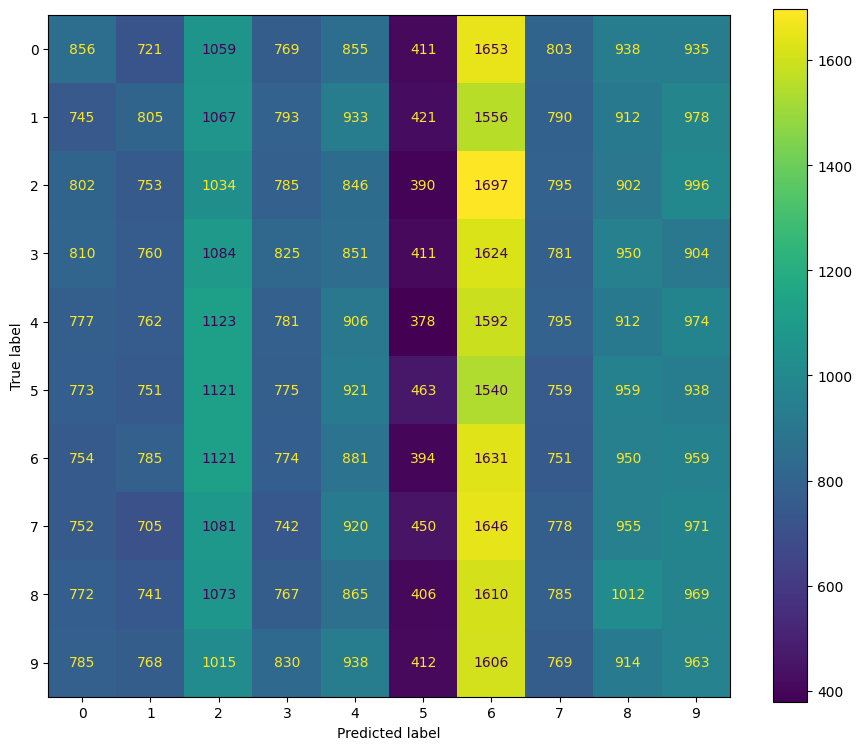

In [44]:
show_confusion_matrix_without_names(model3,test_ds,num_classes)

# Ziarno 1234

In [45]:
SEED = 1234
tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [46]:
model11 = create_model1(num_classes)

In [47]:
model11.compile( 
    loss=loss_func,
    metrics=metrics
)

In [48]:
model11.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                      

In [49]:
history = model11.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 136s 24ms/step - loss: 1.6732 - categorical_accuracy: 0.3957 - auc: 0.8359 - precision: 0.5757 - recall: 0.1942 - f1_score: 0.4288 - val_loss: 1.4623 - val_categorical_accuracy: 0.4851 - val_auc: 0.8763 - val_precision: 0.6632 - val_recall: 0.3214 - val_f1_score: 0.3769
Epoch 2/20
5625/5625 [==============================] - 132s 24ms/step - loss: 1.3851 - categorical_accuracy: 0.4973 - auc: 0.8898 - precision: 0.6789 - recall: 0.3112 - f1_score: 0.3995 - val_loss: 1.2753 - val_categorical_accuracy: 0.5364 - val_auc: 0.9080 - val_precision: 0.6785 - val_recall: 0.3938 - val_f1_score: 0.4520
Epoch 3/20
5625/5625 [==============================] - 132s 23ms/step - loss: 1.2977 - categorical_accuracy: 0.5312 - auc: 0.9037 - precision: 0.7007 - recall: 0.3598 - f1_score: 0.4505 - val_loss: 1.1887 - val_categorical_accuracy: 0.5753 - val_auc: 0.9196 - val_precision: 0.7184 - val_recall: 0.4387 - val_f1_score: 0.5084
Epoch 4/20
5625/562

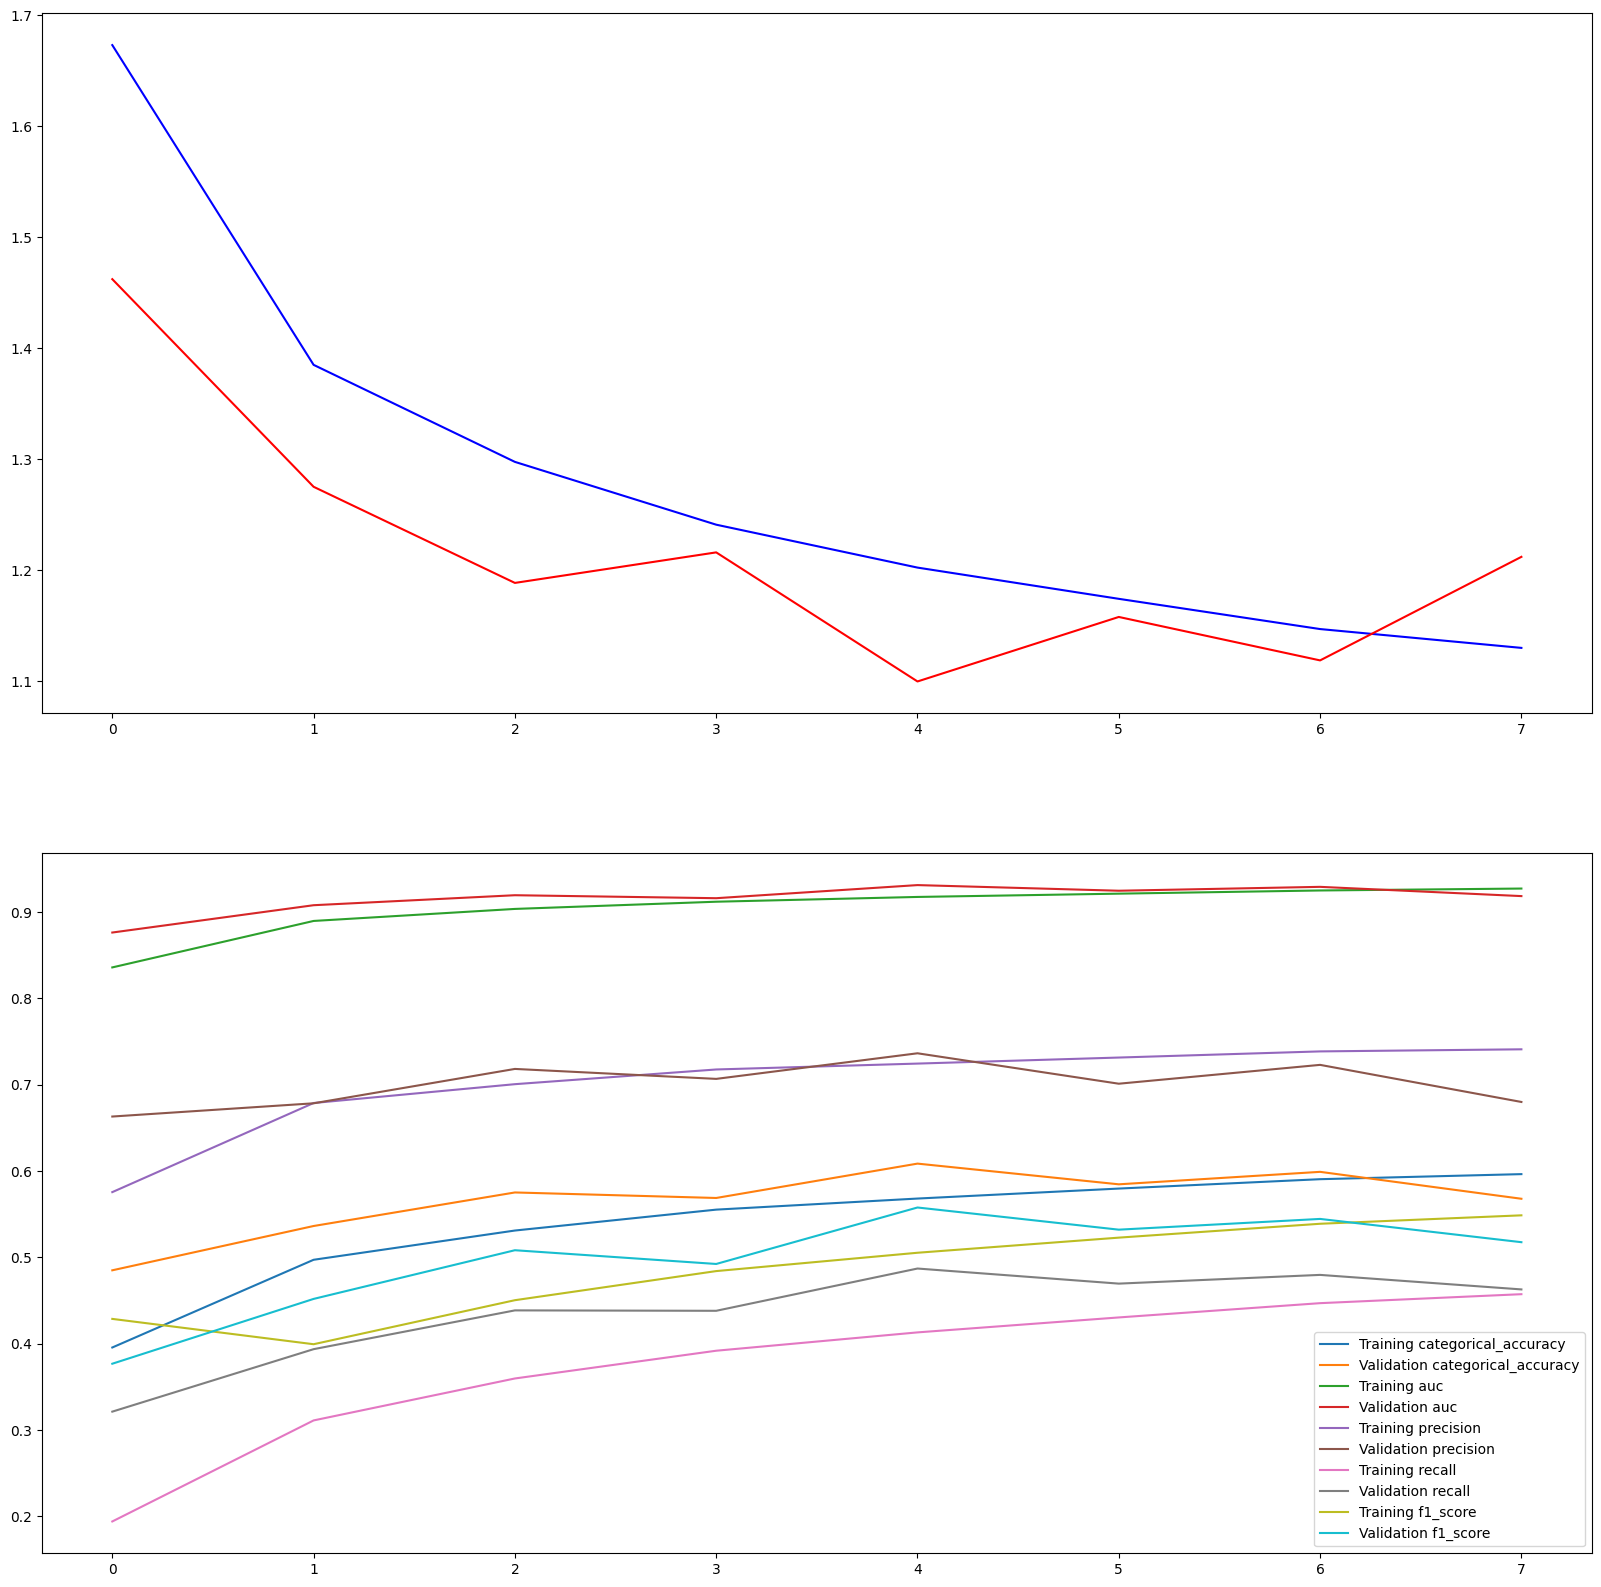

In [50]:
show_training_validation_loss_and_metrics(model11,metrics2)

In [51]:
model11.evaluate(test_it)

5625/5625 [==============================] - 42s 8ms/step - loss: 1.2197 - categorical_accuracy: 0.5653 - auc: 0.9177 - precision: 0.6776 - recall: 0.4617 - f1_score: 0.5162


[1.219667911529541,
 0.56532222032547,
 0.9177035093307495,
 0.6775698065757751,
 0.4617111086845398,
 0.5162052512168884]

5625/5625 [==============================] - 23s 4ms/step


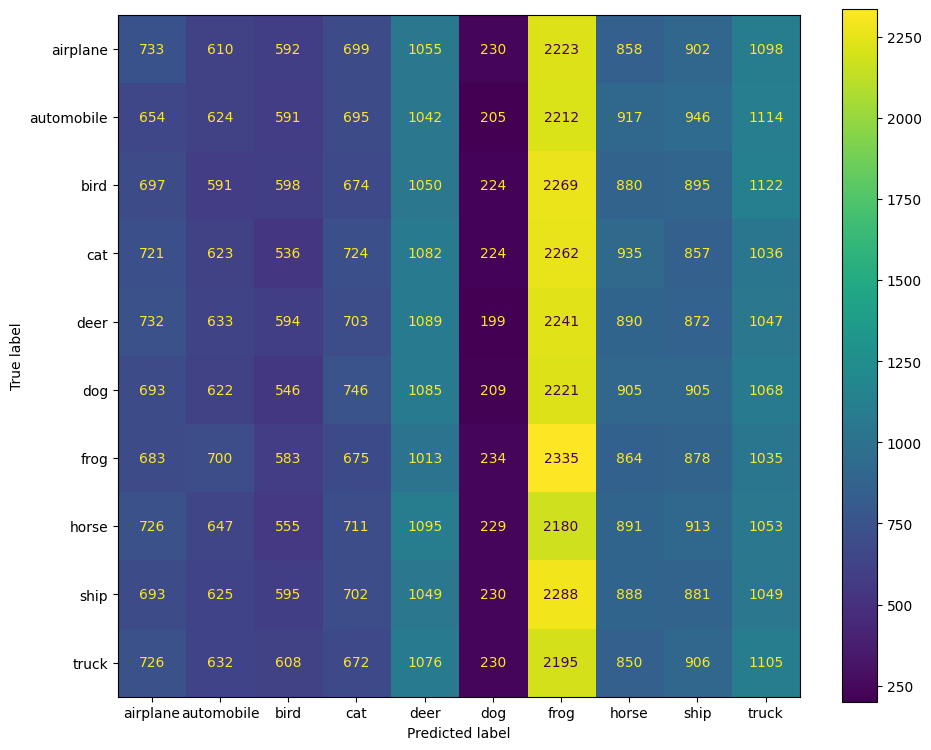

In [52]:
show_confusion_matrix(model11,test_ds,num_classes,class_names)

5625/5625 [==============================] - 22s 4ms/step


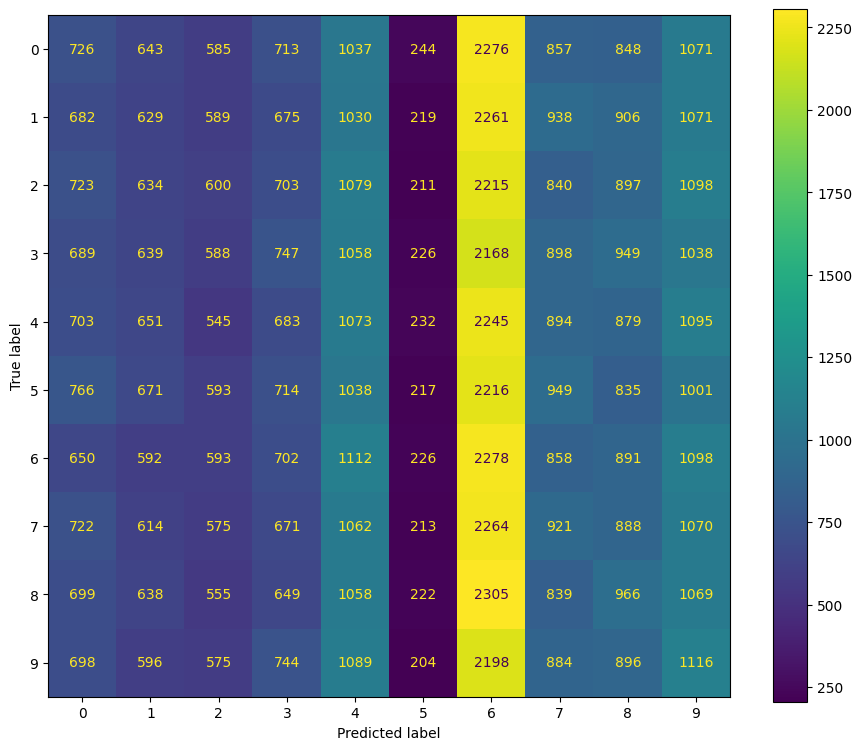

In [53]:
show_confusion_matrix_without_names(model11,test_ds,num_classes)

# Architektura drugiego modelu

In [54]:
model21 = create_model2(num_classes)

In [55]:
model21.compile( 
    loss=loss_func,
    metrics=metrics
)

In [56]:
model21.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_9 (Laye  (None, 32, 32, 75)       150       
 rNormalization)                                                 
                                                                 
 average_pooling2d_3 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_10 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                      

In [57]:
history = model21.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 137s 24ms/step - loss: 1.8145 - categorical_accuracy: 0.3405 - auc: 0.7999 - precision: 0.5699 - recall: 0.1036 - f1_score: 0.3712 - val_loss: 1.6311 - val_categorical_accuracy: 0.4080 - val_auc: 0.8437 - val_precision: 0.6045 - val_recall: 0.2286 - val_f1_score: 0.2829
Epoch 2/20
5625/5625 [==============================] - 137s 24ms/step - loss: 1.5332 - categorical_accuracy: 0.4373 - auc: 0.8629 - precision: 0.6466 - recall: 0.2113 - f1_score: 0.2919 - val_loss: 1.4107 - val_categorical_accuracy: 0.4891 - val_auc: 0.8855 - val_precision: 0.6652 - val_recall: 0.3192 - val_f1_score: 0.3787
Epoch 3/20
5625/5625 [==============================] - 136s 24ms/step - loss: 1.4402 - categorical_accuracy: 0.4757 - auc: 0.8801 - precision: 0.6739 - recall: 0.2664 - f1_score: 0.3542 - val_loss: 1.3115 - val_categorical_accuracy: 0.5249 - val_auc: 0.9017 - val_precision: 0.6969 - val_recall: 0.3434 - val_f1_score: 0.4151
Epoch 4/20
5625/562

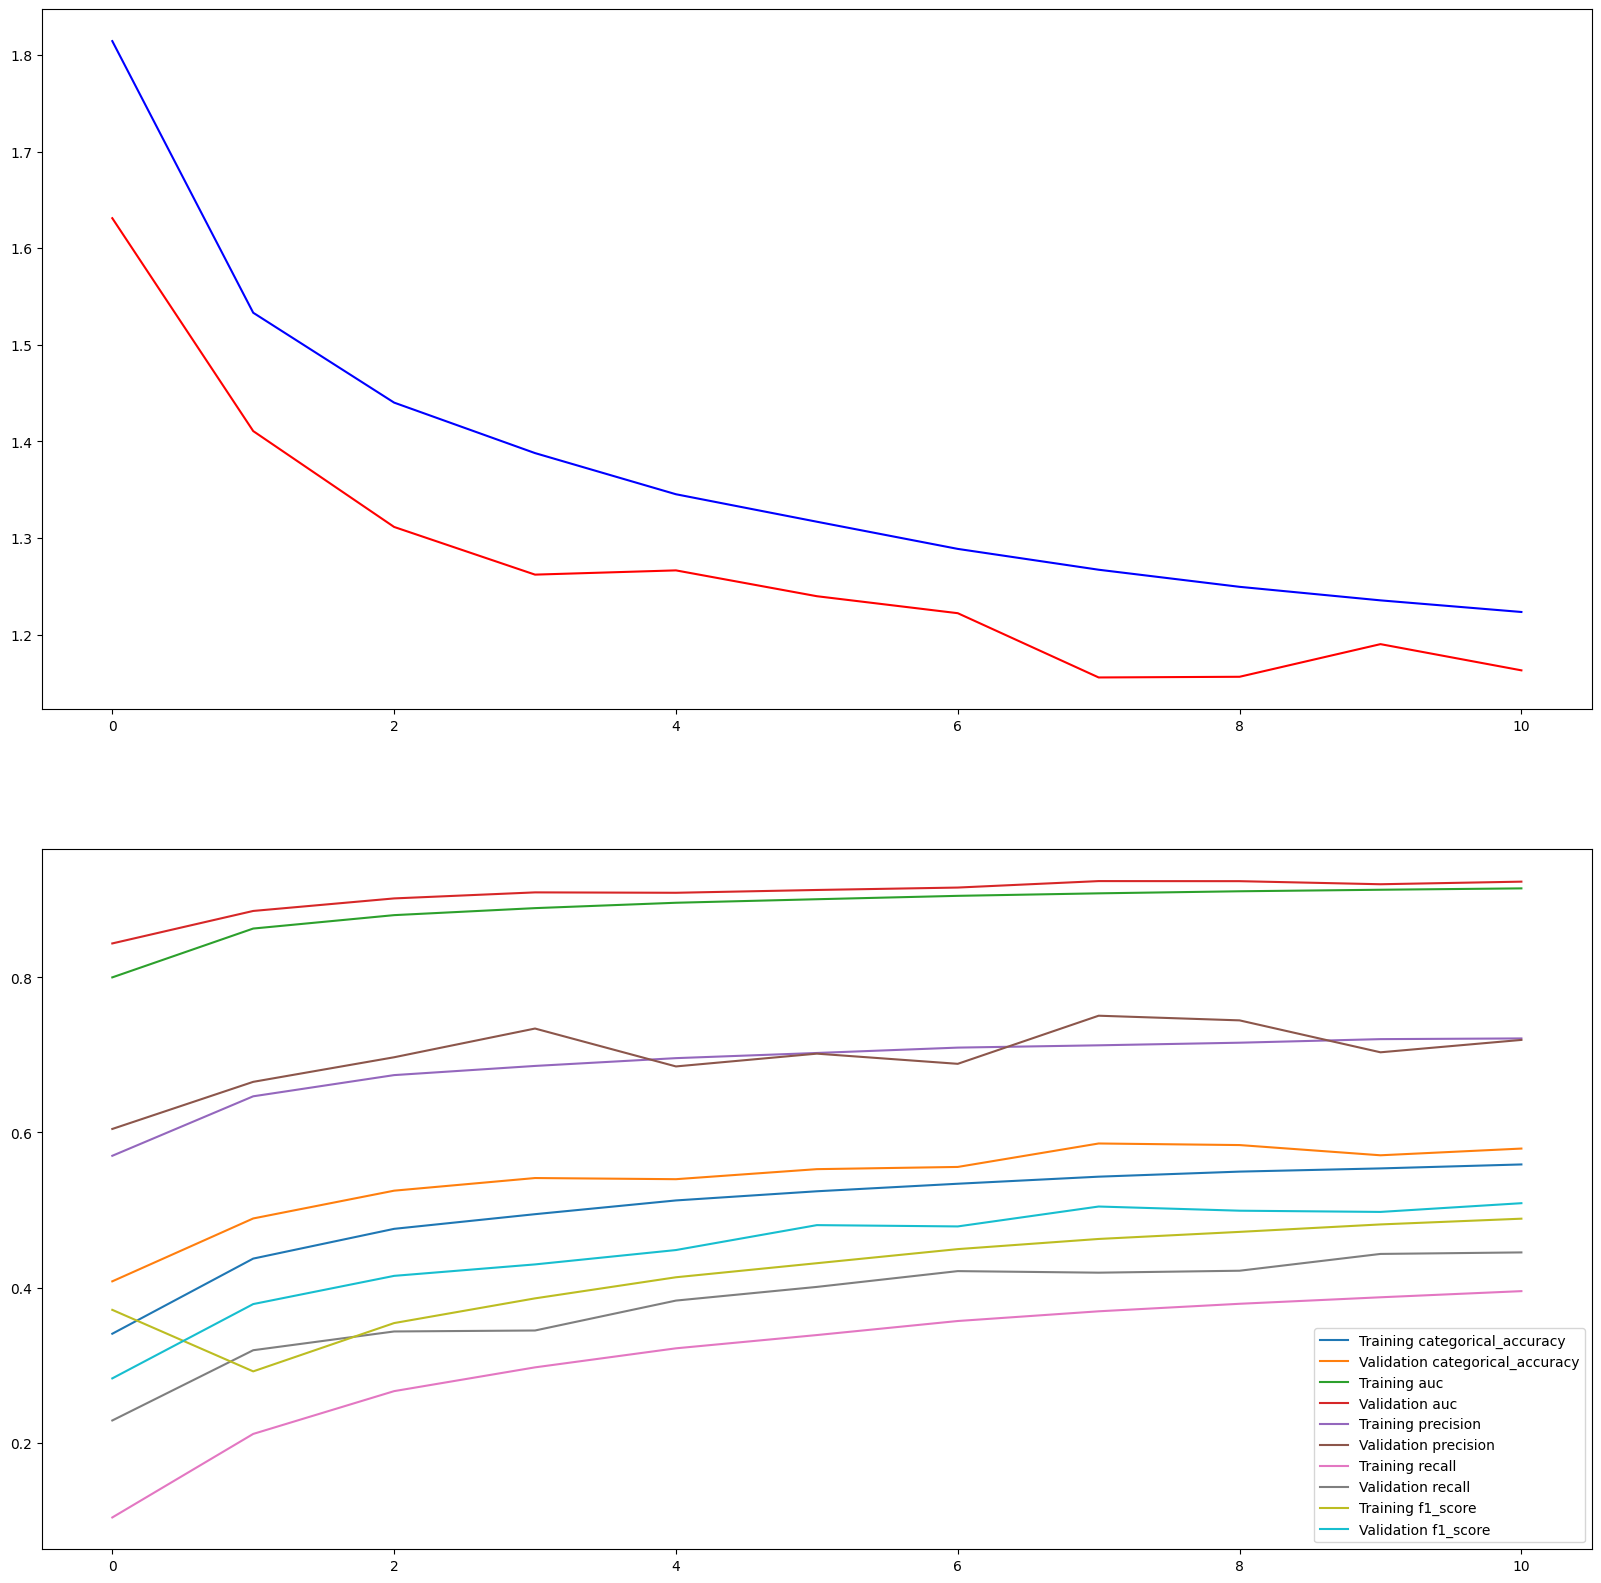

In [58]:
show_training_validation_loss_and_metrics(model21,metrics2)

In [59]:
model21.evaluate(test_it)

5625/5625 [==============================] - 44s 8ms/step - loss: 1.1697 - categorical_accuracy: 0.5758 - auc: 0.9225 - precision: 0.7167 - recall: 0.4439 - f1_score: 0.5069


[1.169707179069519,
 0.5758444666862488,
 0.9224624037742615,
 0.7166845798492432,
 0.44386667013168335,
 0.5068604350090027]

5625/5625 [==============================] - 20s 4ms/step


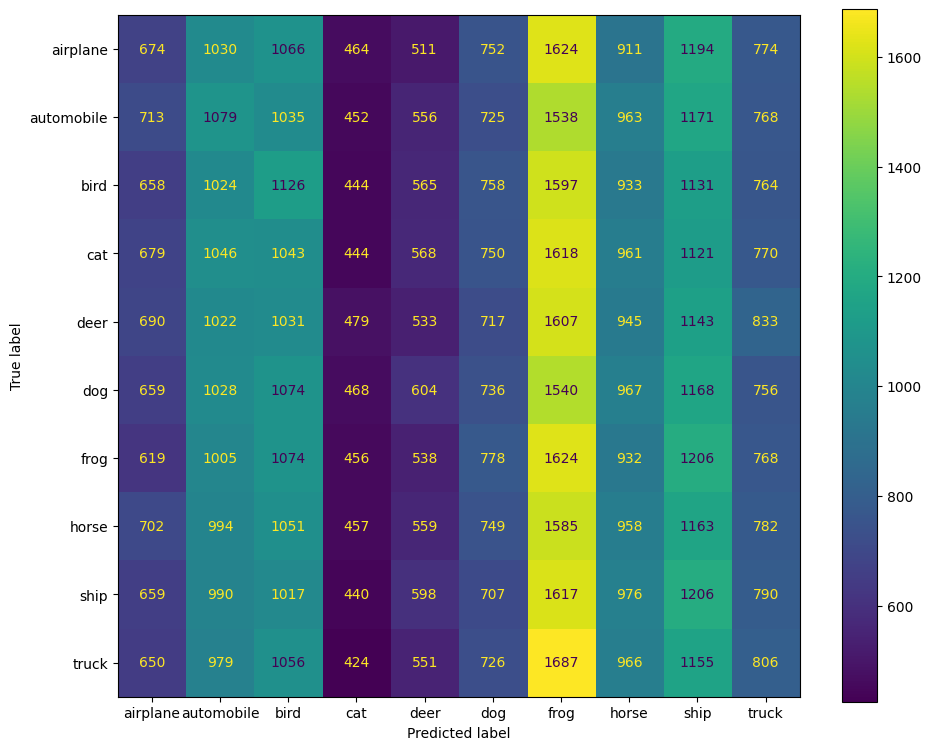

In [60]:
show_confusion_matrix(model21,test_ds,num_classes,class_names)

5625/5625 [==============================] - 19s 3ms/step


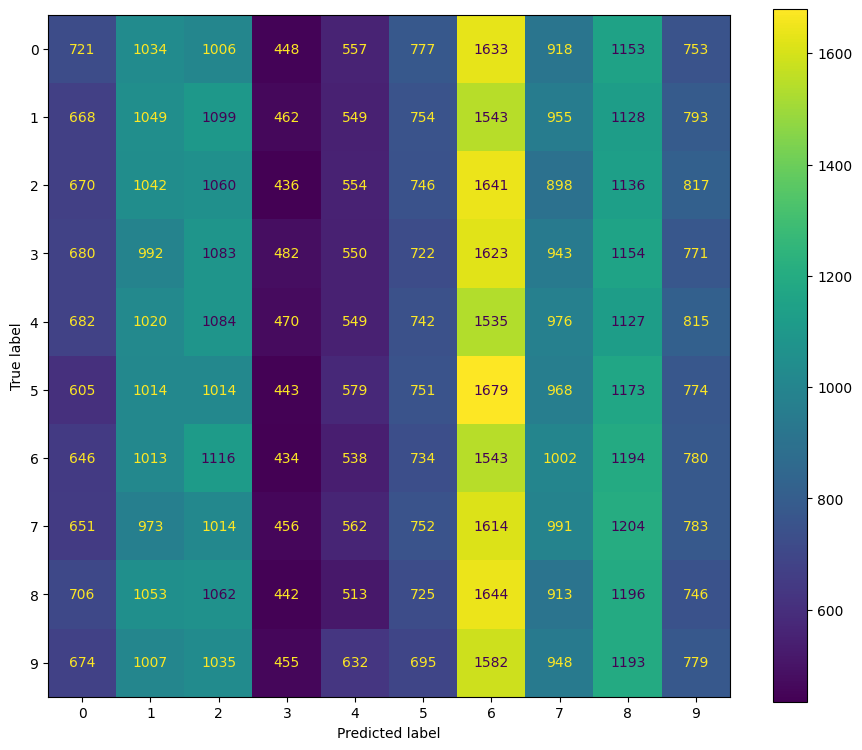

In [61]:
show_confusion_matrix_without_names(model21,test_ds,num_classes)

# Architektura trzeciego modelu

In [62]:
model31 = create_model3(num_classes)

model31.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [63]:
history = model31.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 135s 24ms/step - loss: 1.7725 - categorical_accuracy: 0.3316 - auc: 0.8071 - precision: 0.5943 - recall: 0.0861 - f1_score: 0.3566 - val_loss: 1.5722 - val_categorical_accuracy: 0.4134 - val_auc: 0.8573 - val_precision: 0.5656 - val_recall: 0.2347 - val_f1_score: 0.2702
Epoch 2/20
5625/5625 [==============================] - 134s 24ms/step - loss: 1.5348 - categorical_accuracy: 0.4284 - auc: 0.8627 - precision: 0.6417 - recall: 0.2005 - f1_score: 0.2729 - val_loss: 1.4269 - val_categorical_accuracy: 0.4580 - val_auc: 0.8838 - val_precision: 0.6269 - val_recall: 0.2730 - val_f1_score: 0.3225
Epoch 3/20
5625/5625 [==============================] - 134s 24ms/step - loss: 1.4242 - categorical_accuracy: 0.4769 - auc: 0.8831 - precision: 0.6743 - recall: 0.2680 - f1_score: 0.3487 - val_loss: 1.3534 - val_categorical_accuracy: 0.4964 - val_auc: 0.8959 - val_precision: 0.6454 - val_recall: 0.3420 - val_f1_score: 0.3907
Epoch 4/20
5625/562

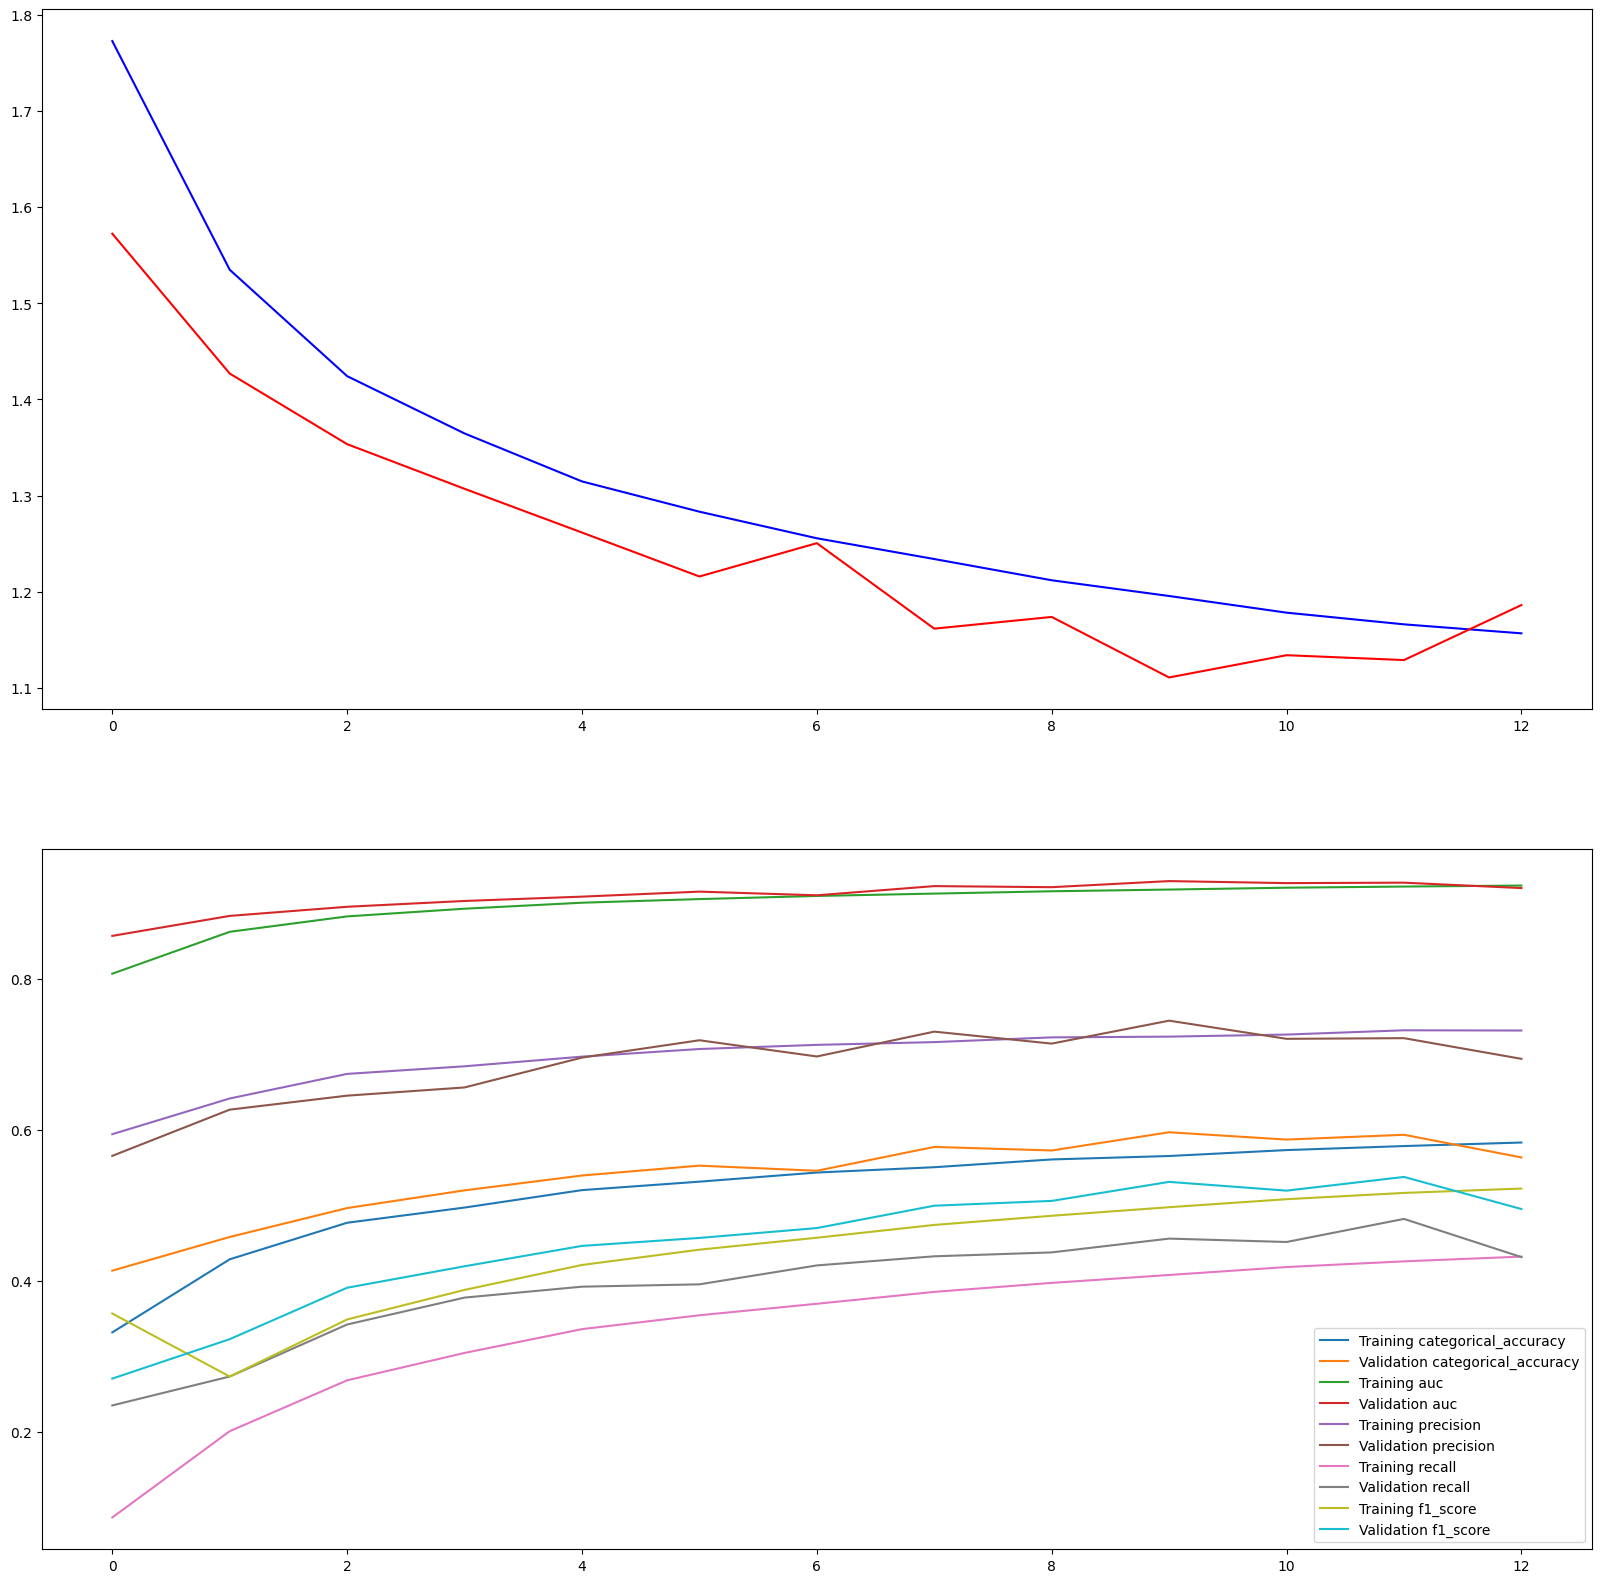

In [64]:
show_training_validation_loss_and_metrics(model31,metrics2)

In [65]:
model31.evaluate(test_it)

5625/5625 [==============================] - 45s 8ms/step - loss: 1.1961 - categorical_accuracy: 0.5620 - auc: 0.9192 - precision: 0.6947 - recall: 0.4319 - f1_score: 0.4957


[1.1961463689804077,
 0.561988890171051,
 0.9192308783531189,
 0.6946598887443542,
 0.4318777918815613,
 0.49569883942604065]

5625/5625 [==============================] - 21s 4ms/step


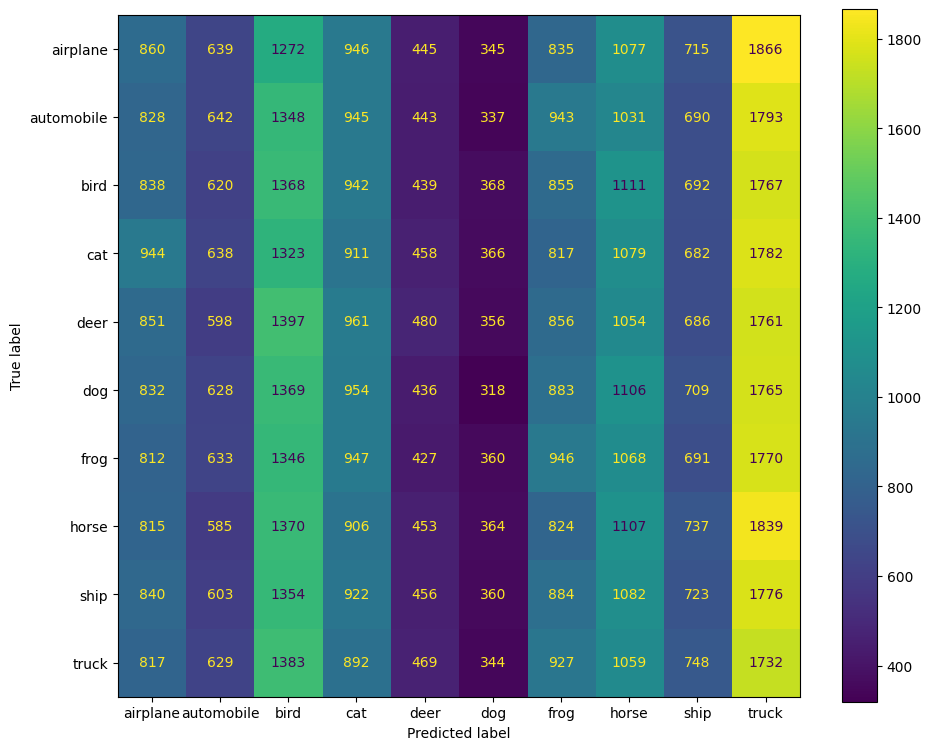

In [66]:
show_confusion_matrix(model31,test_ds,num_classes,class_names)

5625/5625 [==============================] - 21s 4ms/step


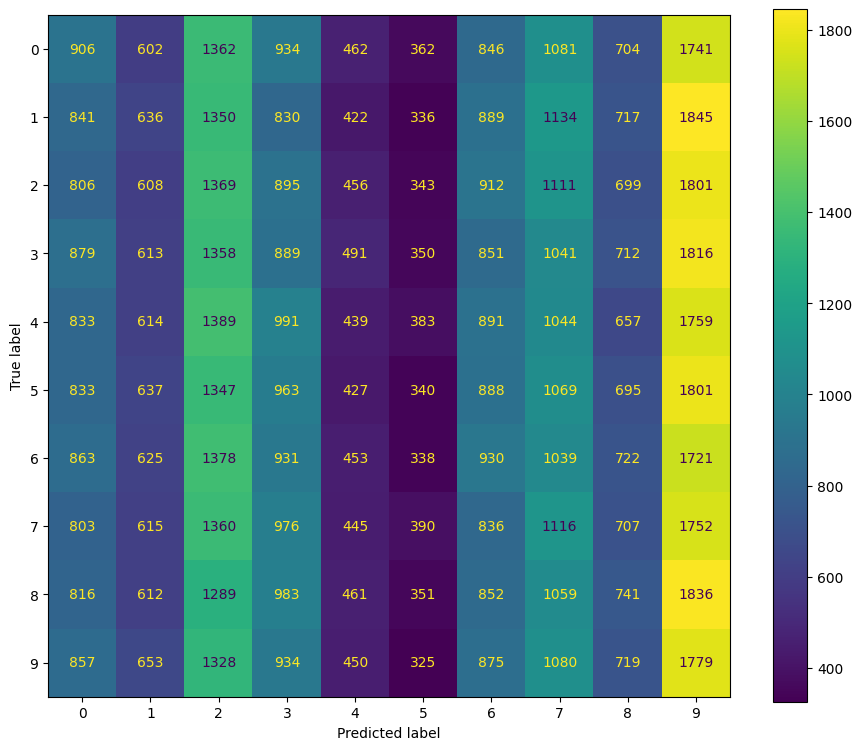

In [67]:
show_confusion_matrix_without_names(model31,test_ds,num_classes)

# Ziarno 2137

In [68]:
SEED = 2137

tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [69]:
model12 = create_model1(num_classes)

In [70]:
model12.compile( 
    loss=loss_func,
    metrics=metrics
)

In [71]:
model12.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_9 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                      

In [72]:
history = model12.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 137s 24ms/step - loss: 1.6760 - categorical_accuracy: 0.3918 - auc: 0.8353 - precision: 0.5747 - recall: 0.1909 - f1_score: 0.3950 - val_loss: 1.3510 - val_categorical_accuracy: 0.5094 - val_auc: 0.8955 - val_precision: 0.6880 - val_recall: 0.3308 - val_f1_score: 0.4153
Epoch 2/20
5625/5625 [==============================] - 135s 24ms/step - loss: 1.3838 - categorical_accuracy: 0.4991 - auc: 0.8900 - precision: 0.6787 - recall: 0.3105 - f1_score: 0.3986 - val_loss: 1.3530 - val_categorical_accuracy: 0.5202 - val_auc: 0.8947 - val_precision: 0.7125 - val_recall: 0.3374 - val_f1_score: 0.4340
Epoch 3/20
5625/5625 [==============================] - 135s 24ms/step - loss: 1.2910 - categorical_accuracy: 0.5331 - auc: 0.9047 - precision: 0.7042 - recall: 0.3636 - f1_score: 0.4548 - val_loss: 1.3297 - val_categorical_accuracy: 0.5342 - val_auc: 0.9000 - val_precision: 0.6760 - val_recall: 0.4063 - val_f1_score: 0.4528
Epoch 4/20
5625/562

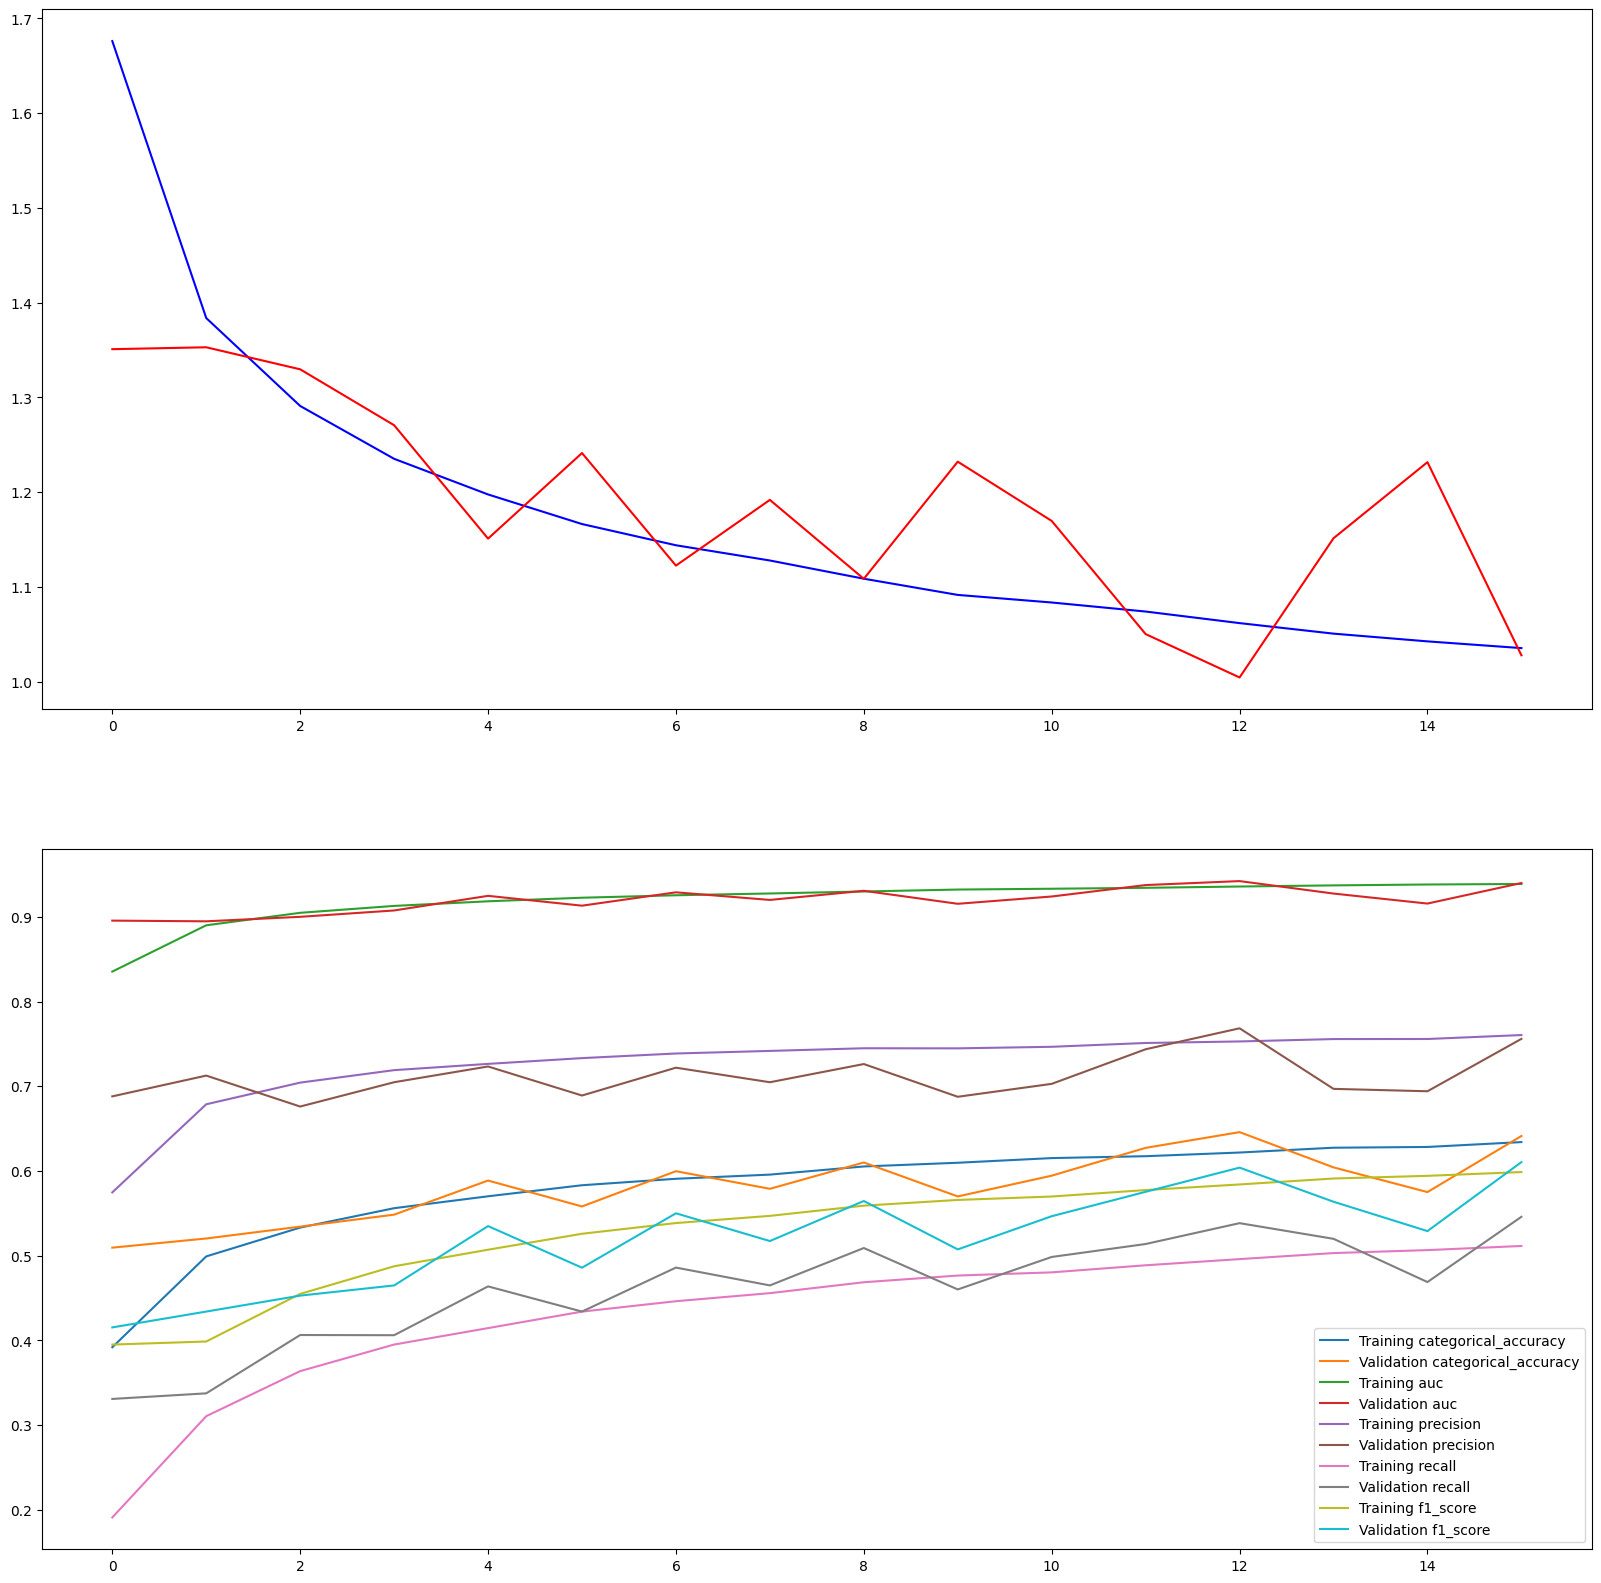

In [73]:
show_training_validation_loss_and_metrics(model12,metrics2)

In [74]:
model12.evaluate(test_it)

5625/5625 [==============================] - 44s 8ms/step - loss: 1.0386 - categorical_accuracy: 0.6403 - auc: 0.9385 - precision: 0.7534 - recall: 0.5444 - f1_score: 0.6094


[1.038616418838501,
 0.6403444409370422,
 0.9384797811508179,
 0.7533791661262512,
 0.5443666577339172,
 0.6094092130661011]

5625/5625 [==============================] - 22s 4ms/step


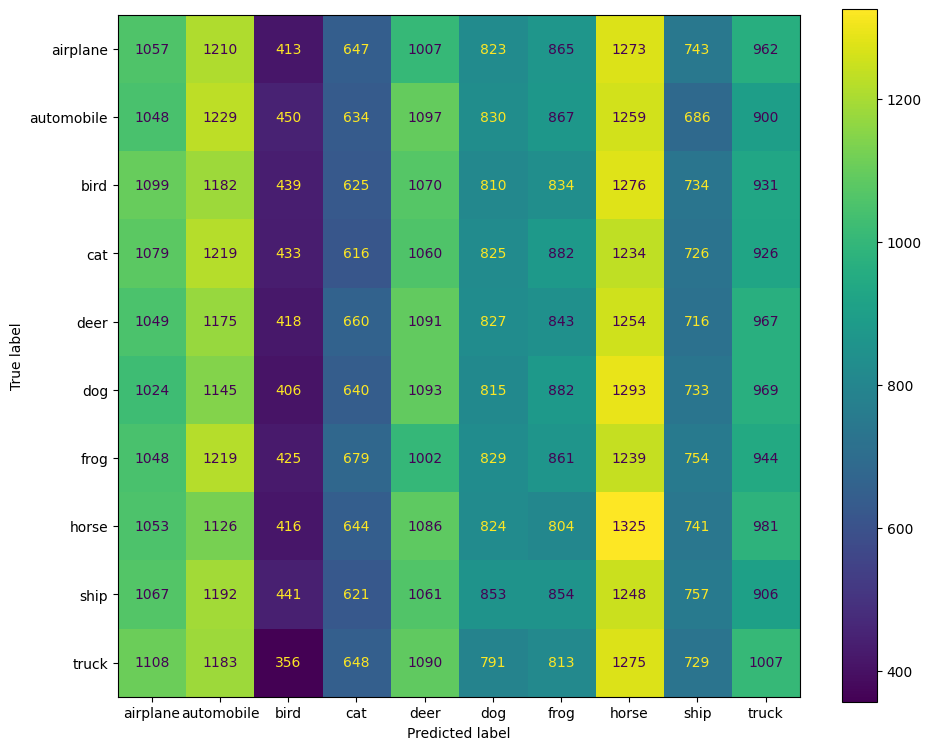

In [75]:
show_confusion_matrix(model12,test_ds,num_classes,class_names)

5625/5625 [==============================] - 22s 4ms/step


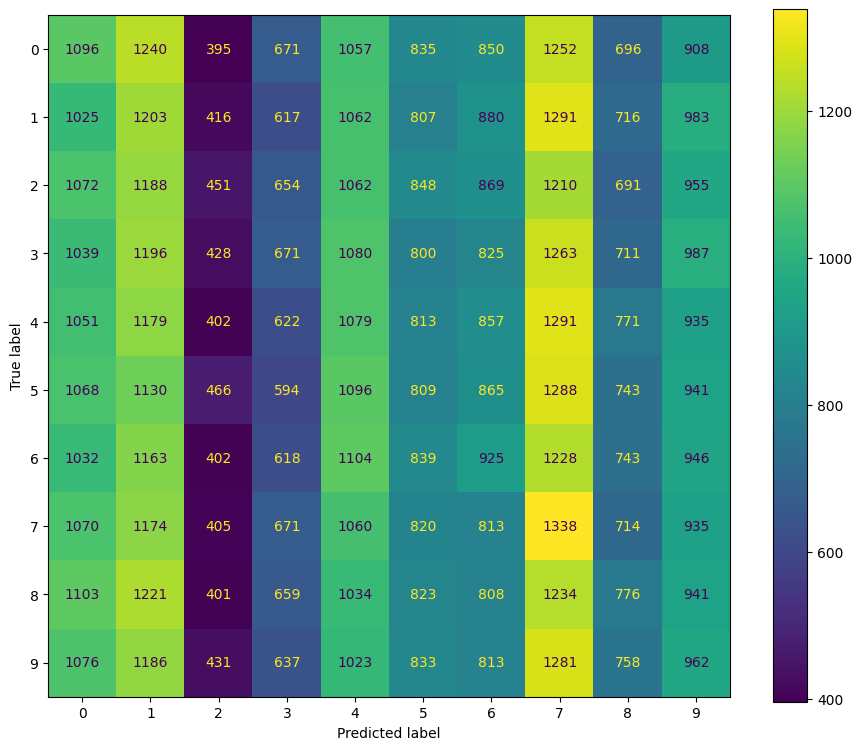

In [76]:
show_confusion_matrix_without_names(model12,test_ds,num_classes)

# Architektura drugiego modelu

In [77]:
model22 = create_model2(num_classes)

In [78]:
model22.compile( 
    loss=loss_func,
    metrics=metrics
)

In [79]:
model22.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_18 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_6 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_19 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                      

In [80]:
history = model22.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 136s 24ms/step - loss: 1.8091 - categorical_accuracy: 0.3443 - auc: 0.8015 - precision: 0.5711 - recall: 0.1072 - f1_score: 0.4287 - val_loss: 1.5238 - val_categorical_accuracy: 0.4441 - val_auc: 0.8657 - val_precision: 0.6909 - val_recall: 0.1748 - val_f1_score: 0.2506
Epoch 2/20
5625/5625 [==============================] - 133s 24ms/step - loss: 1.5310 - categorical_accuracy: 0.4413 - auc: 0.8631 - precision: 0.6535 - recall: 0.2159 - f1_score: 0.2968 - val_loss: 1.4174 - val_categorical_accuracy: 0.4873 - val_auc: 0.8838 - val_precision: 0.6861 - val_recall: 0.2926 - val_f1_score: 0.3659
Epoch 3/20
5625/5625 [==============================] - 133s 24ms/step - loss: 1.4550 - categorical_accuracy: 0.4694 - auc: 0.8775 - precision: 0.6704 - recall: 0.2582 - f1_score: 0.3434 - val_loss: 1.3768 - val_categorical_accuracy: 0.5019 - val_auc: 0.8910 - val_precision: 0.6799 - val_recall: 0.3218 - val_f1_score: 0.3887
Epoch 4/20
5625/562

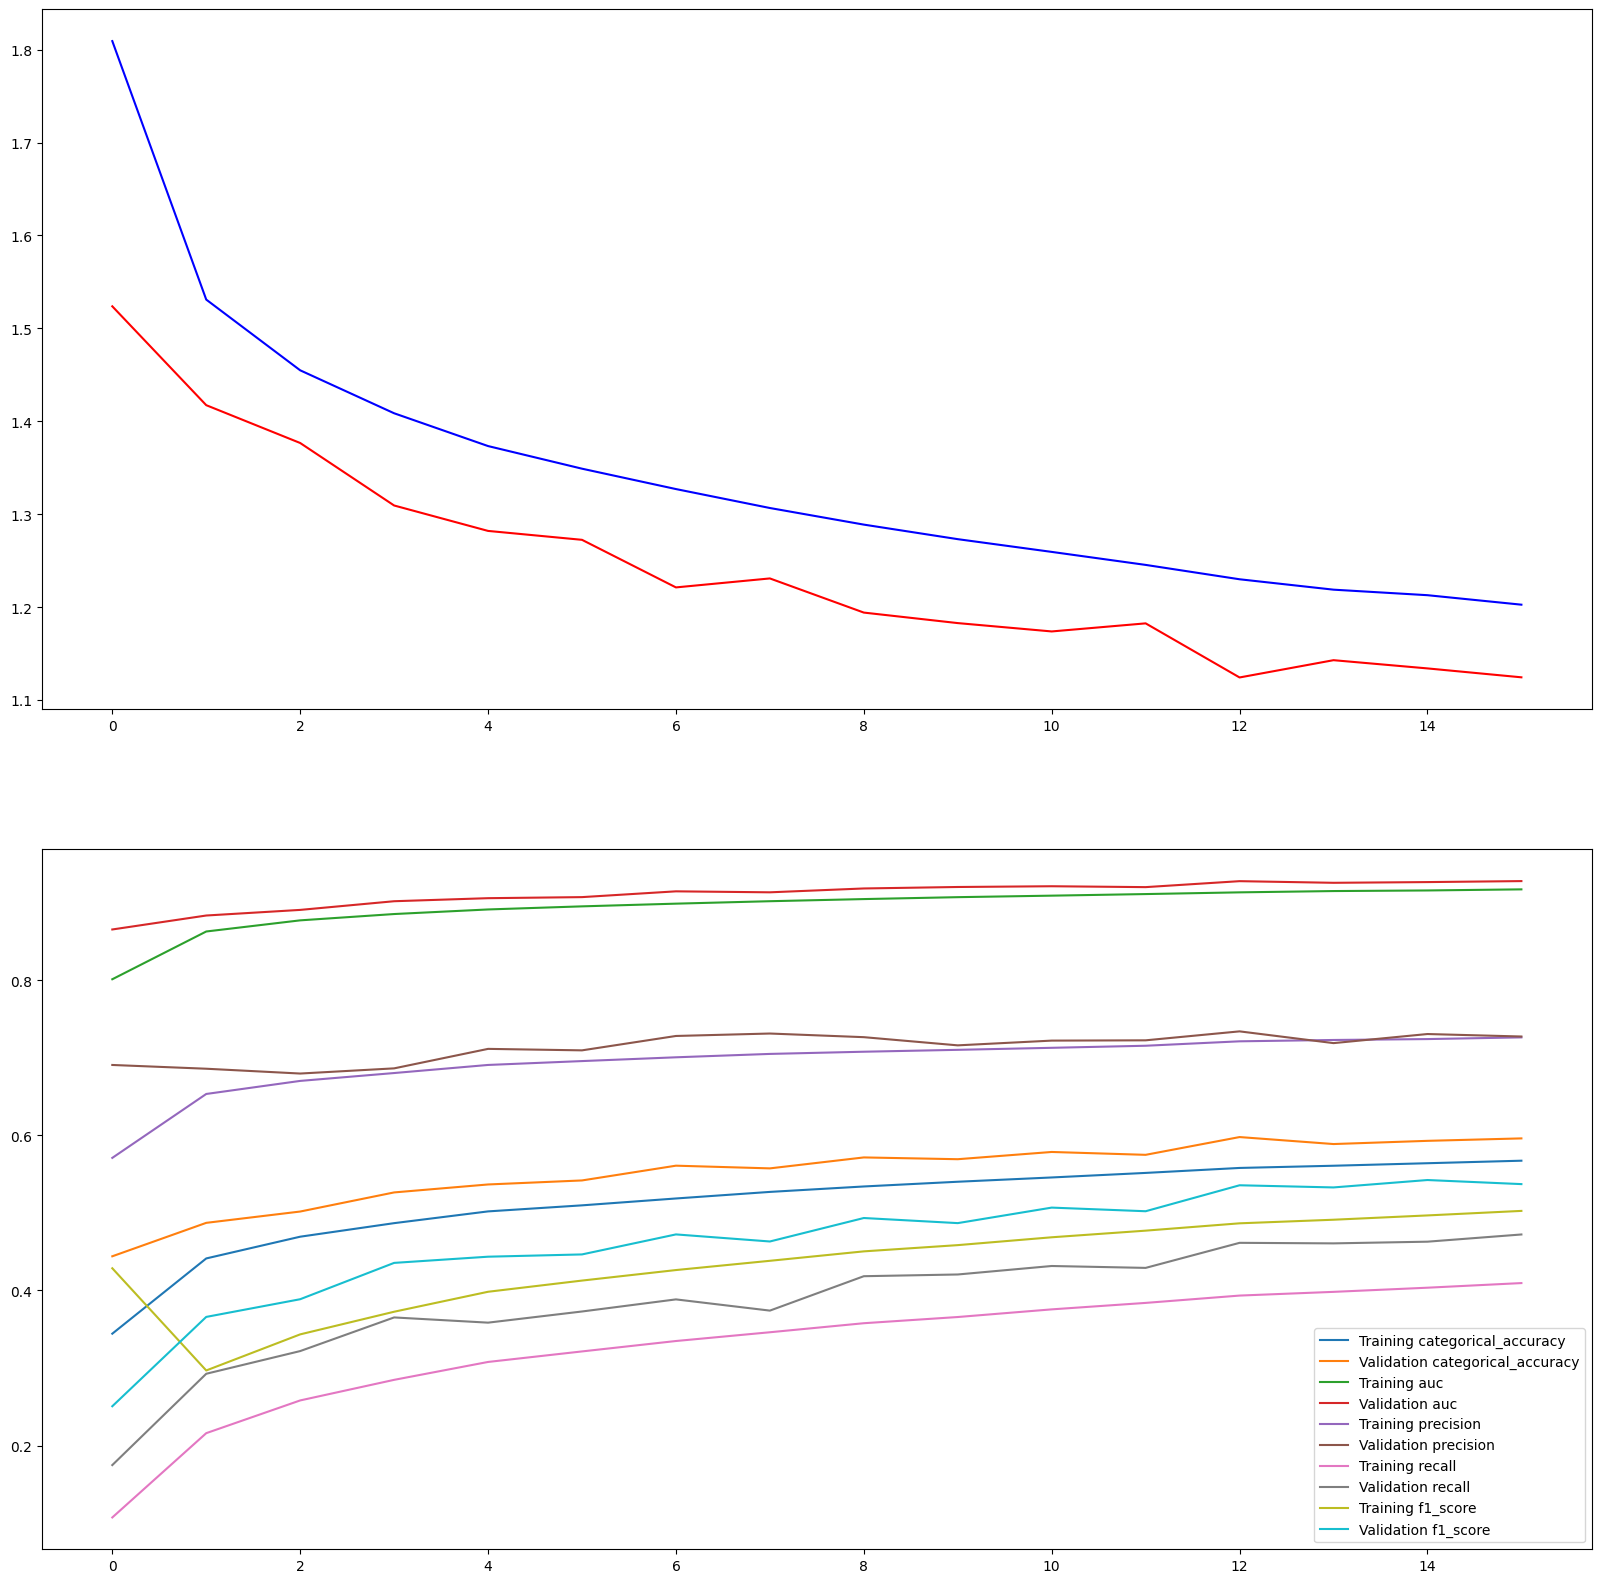

In [81]:
show_training_validation_loss_and_metrics(model22,metrics2)

In [82]:
model22.evaluate(test_it)

5625/5625 [==============================] - 45s 8ms/step - loss: 1.1331 - categorical_accuracy: 0.5942 - auc: 0.9271 - precision: 0.7248 - recall: 0.4703 - f1_score: 0.5356


[1.1331171989440918,
 0.5941555500030518,
 0.9270581603050232,
 0.7248441576957703,
 0.47031110525131226,
 0.5355952382087708]

5625/5625 [==============================] - 20s 4ms/step


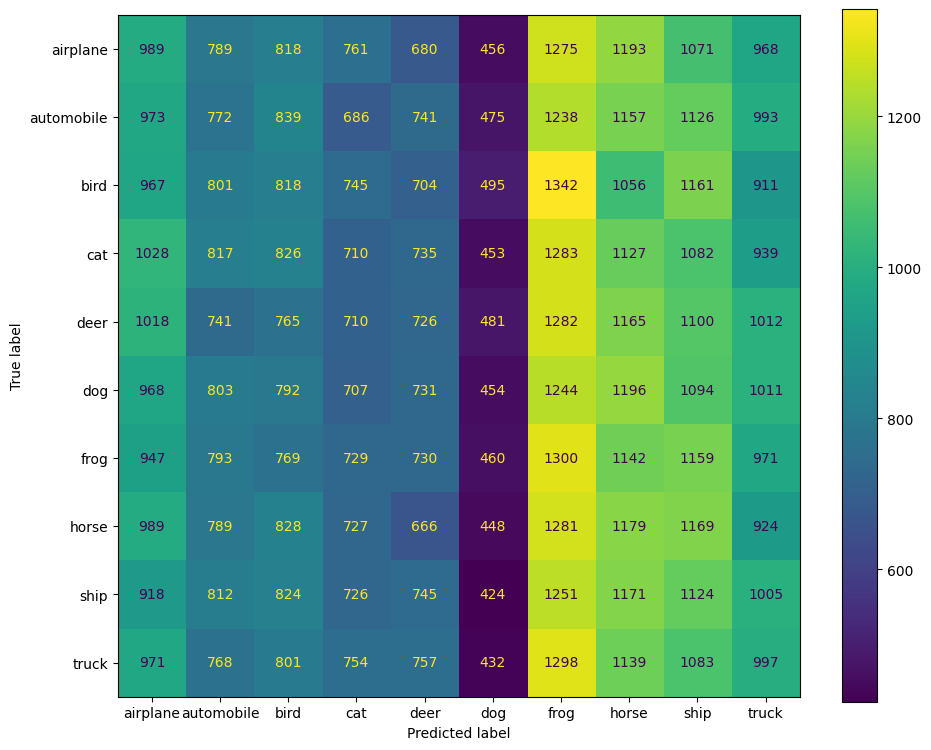

In [83]:
show_confusion_matrix(model22,test_ds,num_classes,class_names)

5625/5625 [==============================] - 20s 4ms/step


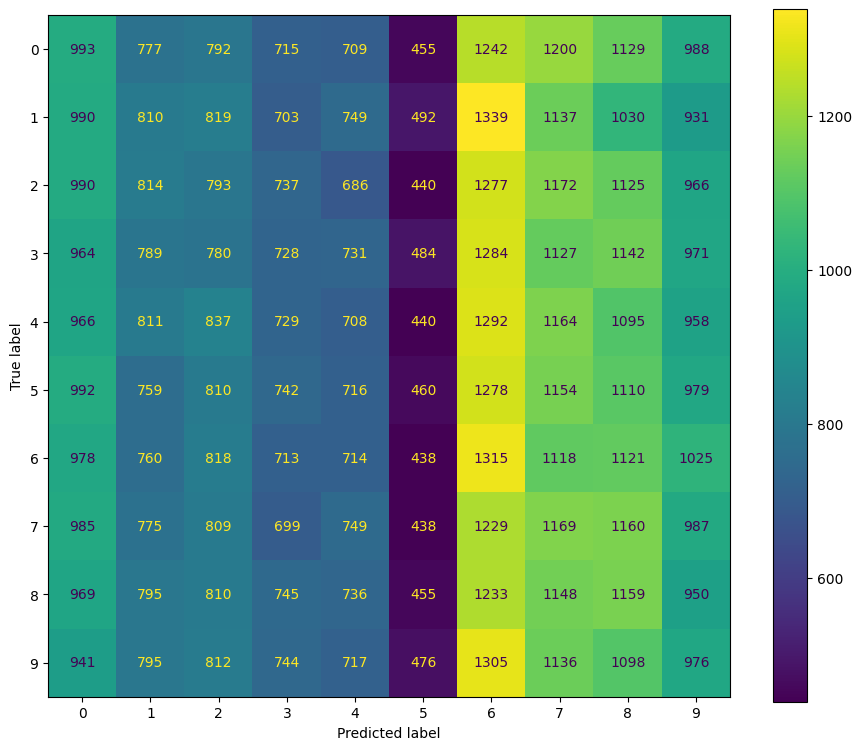

In [84]:
show_confusion_matrix_without_names(model22,test_ds,num_classes)

# Architektura trzeciego modelu

In [85]:
model32 = create_model3(num_classes)

model32.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [86]:
model32.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 layer_normalization_22 (Lay  (None, 32, 32, 256)      512       
 erNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 layer_normalization_23 (Lay  (None, 16, 16, 128)      256       
 erNormalization)                                                
                                                      

In [87]:
history = model32.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 134s 24ms/step - loss: 1.7609 - categorical_accuracy: 0.3350 - auc: 0.8096 - precision: 0.6024 - recall: 0.0933 - f1_score: 0.3771 - val_loss: 1.5627 - val_categorical_accuracy: 0.4124 - val_auc: 0.8575 - val_precision: 0.6072 - val_recall: 0.2151 - val_f1_score: 0.2593
Epoch 2/20
5625/5625 [==============================] - 132s 23ms/step - loss: 1.5148 - categorical_accuracy: 0.4372 - auc: 0.8664 - precision: 0.6563 - recall: 0.2156 - f1_score: 0.2897 - val_loss: 1.4137 - val_categorical_accuracy: 0.4737 - val_auc: 0.8850 - val_precision: 0.6576 - val_recall: 0.2869 - val_f1_score: 0.3413
Epoch 3/20
5625/5625 [==============================] - 132s 23ms/step - loss: 1.4173 - categorical_accuracy: 0.4778 - auc: 0.8843 - precision: 0.6771 - recall: 0.2699 - f1_score: 0.3493 - val_loss: 1.3939 - val_categorical_accuracy: 0.4917 - val_auc: 0.8900 - val_precision: 0.6373 - val_recall: 0.3364 - val_f1_score: 0.3707
Epoch 4/20
5625/562

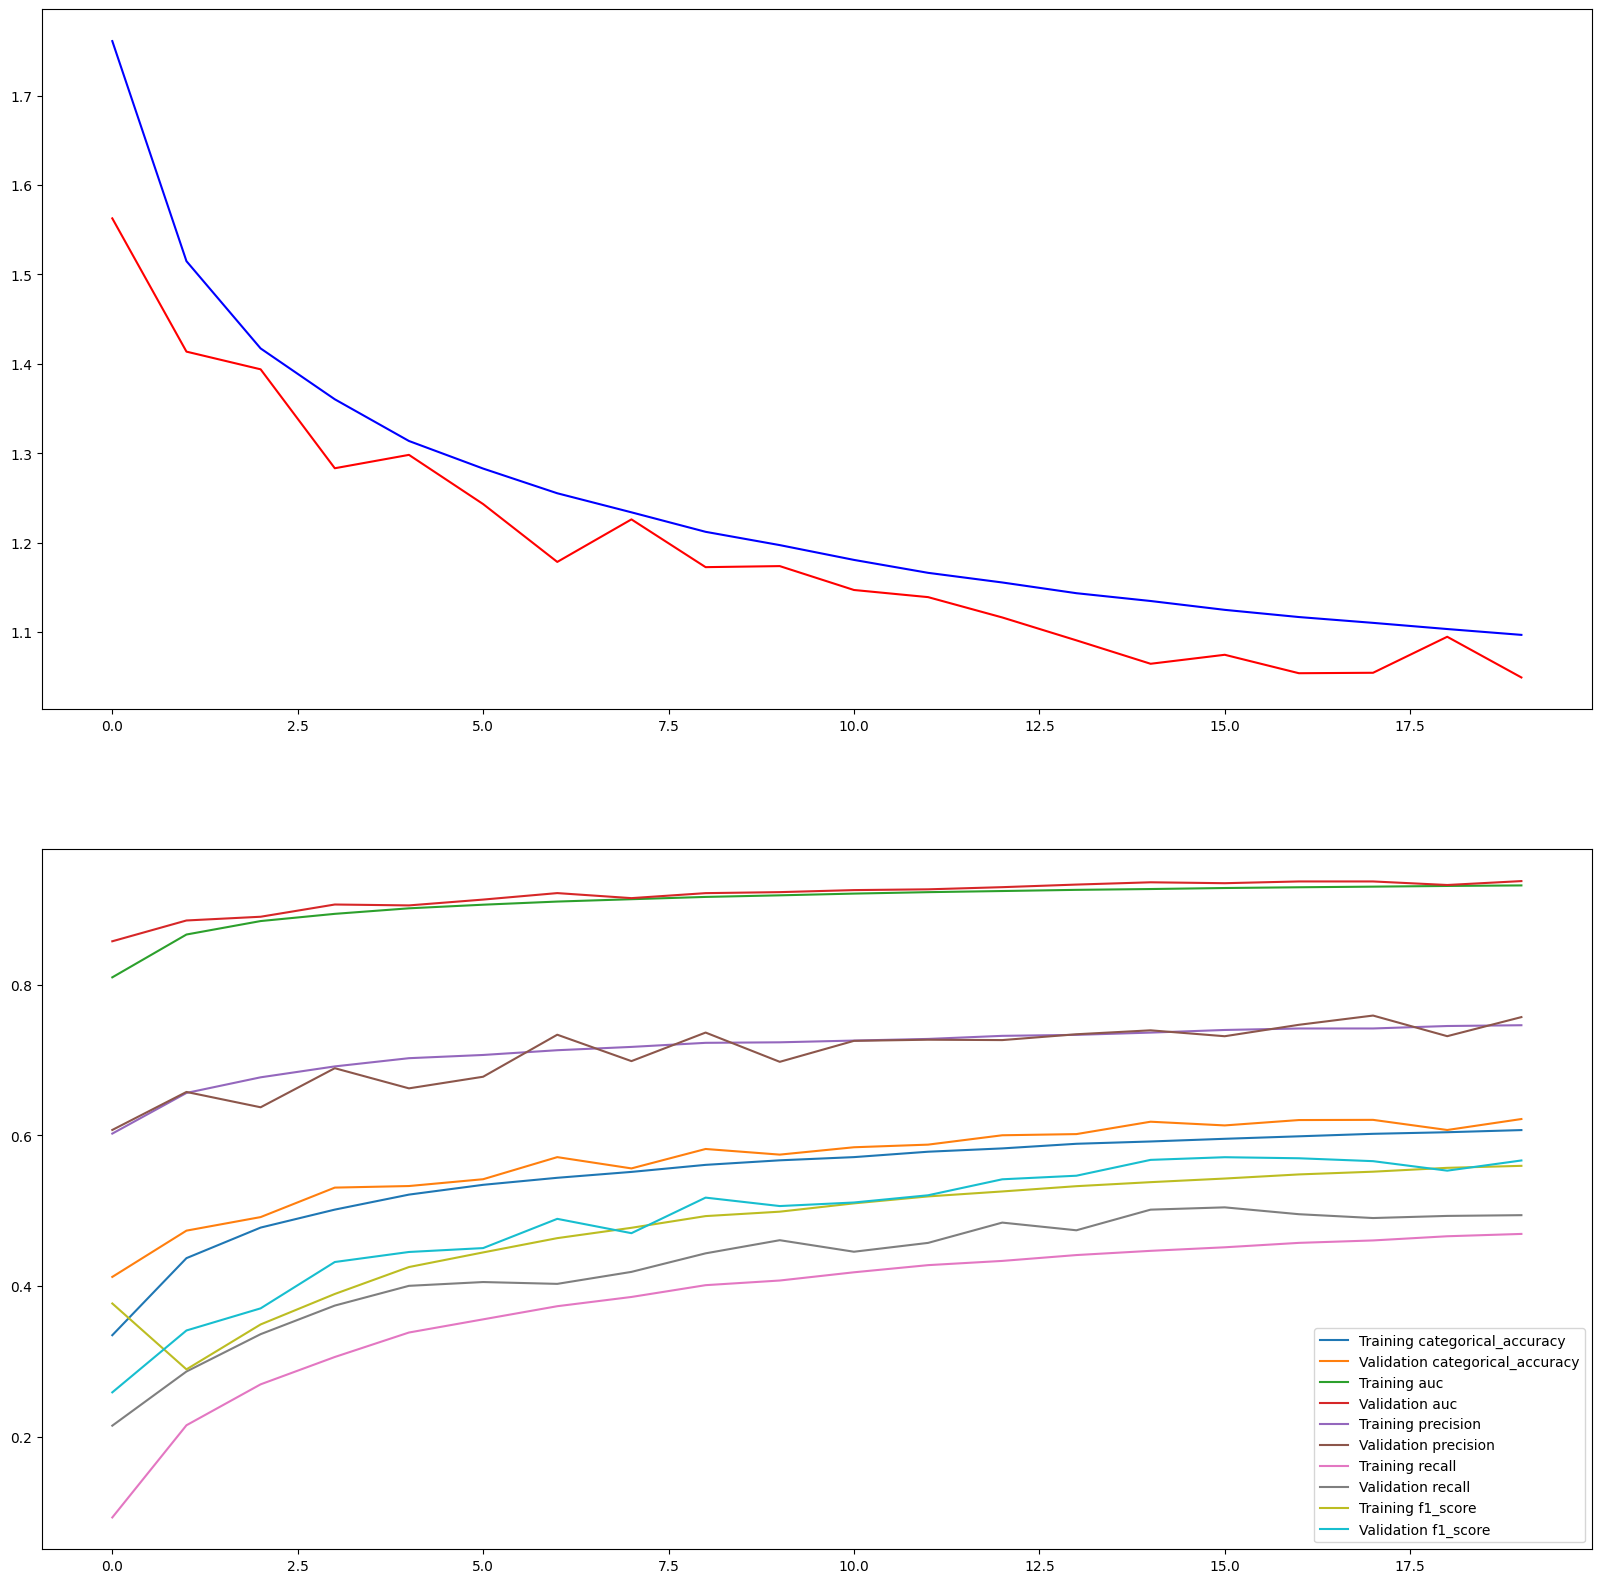

In [88]:
show_training_validation_loss_and_metrics(model32,metrics2)

In [89]:
model32.evaluate(test_it)

5625/5625 [==============================] - 42s 7ms/step - loss: 1.0617 - categorical_accuracy: 0.6201 - auc: 0.9357 - precision: 0.7521 - recall: 0.4929 - f1_score: 0.5650


[1.0616563558578491,
 0.6201221942901611,
 0.9357450008392334,
 0.7520979046821594,
 0.49293333292007446,
 0.565008282661438]

5625/5625 [==============================] - 21s 4ms/step


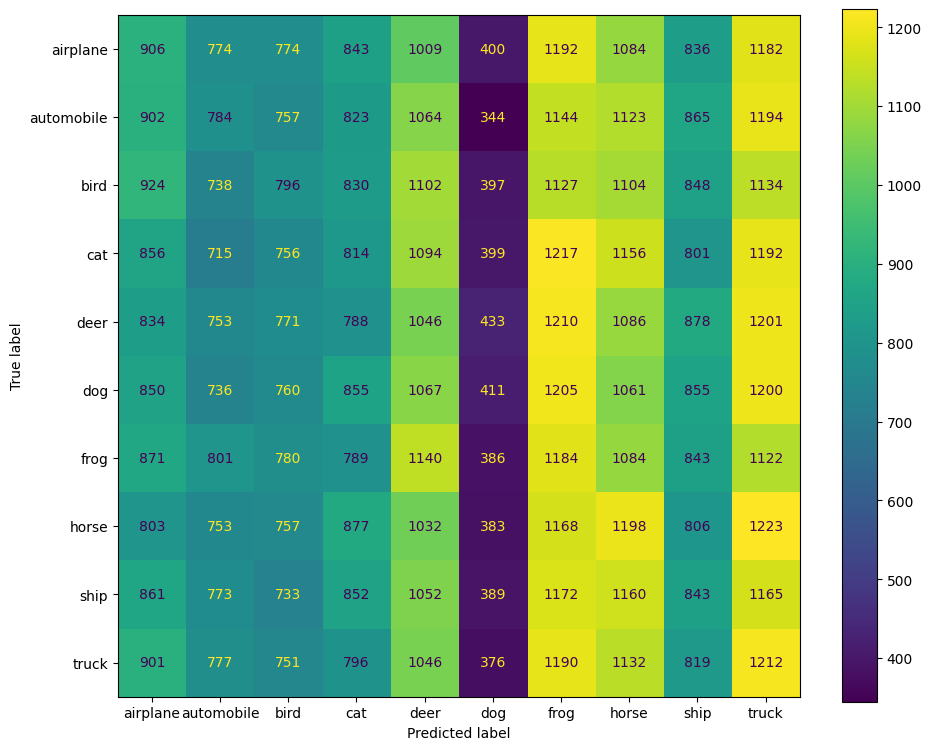

In [90]:
show_confusion_matrix(model32,test_ds,num_classes,class_names)

5625/5625 [==============================] - 21s 4ms/step


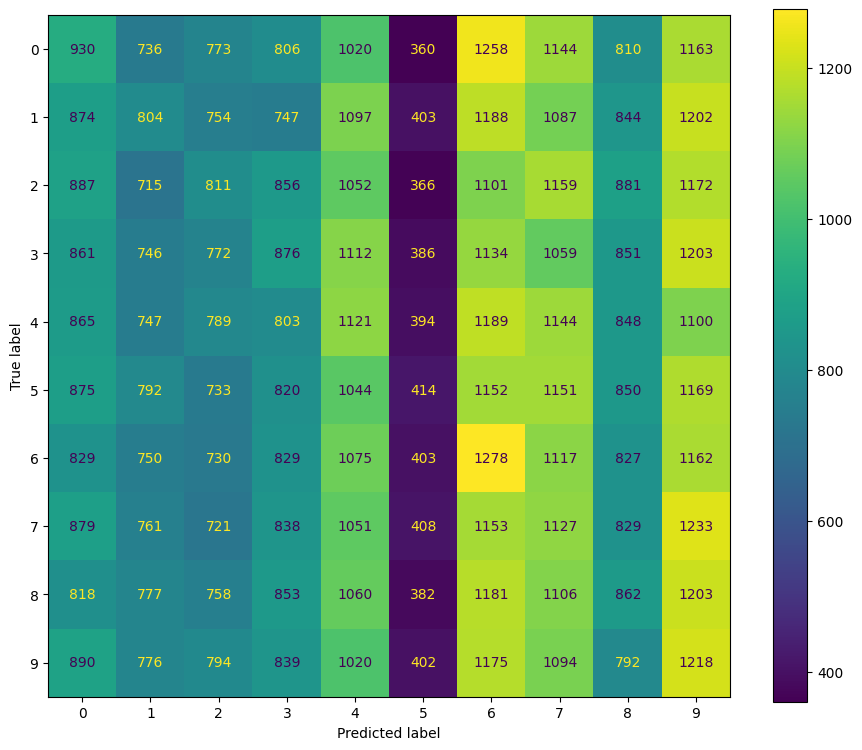

In [91]:
show_confusion_matrix_without_names(model32,test_ds,num_classes)

# Ziarno 7654

In [92]:
SEED = 7654

tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [94]:
model13 = create_model1(num_classes)

In [95]:
model13.compile( 
    loss=loss_func,
    metrics=metrics
)

In [96]:

model13.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                      

In [97]:
history = model13.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20


5625/5625 [==============================] - 136s 24ms/step - loss: 1.6777 - categorical_accuracy: 0.3924 - auc: 0.8348 - precision: 0.5728 - recall: 0.1899 - f1_score: 0.4326 - val_loss: 1.5091 - val_categorical_accuracy: 0.4522 - val_auc: 0.8702 - val_precision: 0.5959 - val_recall: 0.2751 - val_f1_score: 0.3181
Epoch 2/20
5625/5625 [==============================] - 134s 24ms/step - loss: 1.3812 - categorical_accuracy: 0.4981 - auc: 0.8904 - precision: 0.6777 - recall: 0.3133 - f1_score: 0.4022 - val_loss: 1.2595 - val_categorical_accuracy: 0.5400 - val_auc: 0.9101 - val_precision: 0.6967 - val_recall: 0.3922 - val_f1_score: 0.4467
Epoch 3/20
5625/5625 [==============================] - 133s 24ms/step - loss: 1.2882 - categorical_accuracy: 0.5342 - auc: 0.9051 - precision: 0.7055 - recall: 0.3680 - f1_score: 0.4596 - val_loss: 1.2629 - val_categorical_accuracy: 0.5444 - val_auc: 0.9091 - val_precision: 0.7038 - val_recall: 0.3985 - val_f1_score: 0.4557
Epoch 4/20
5625/5625 [========

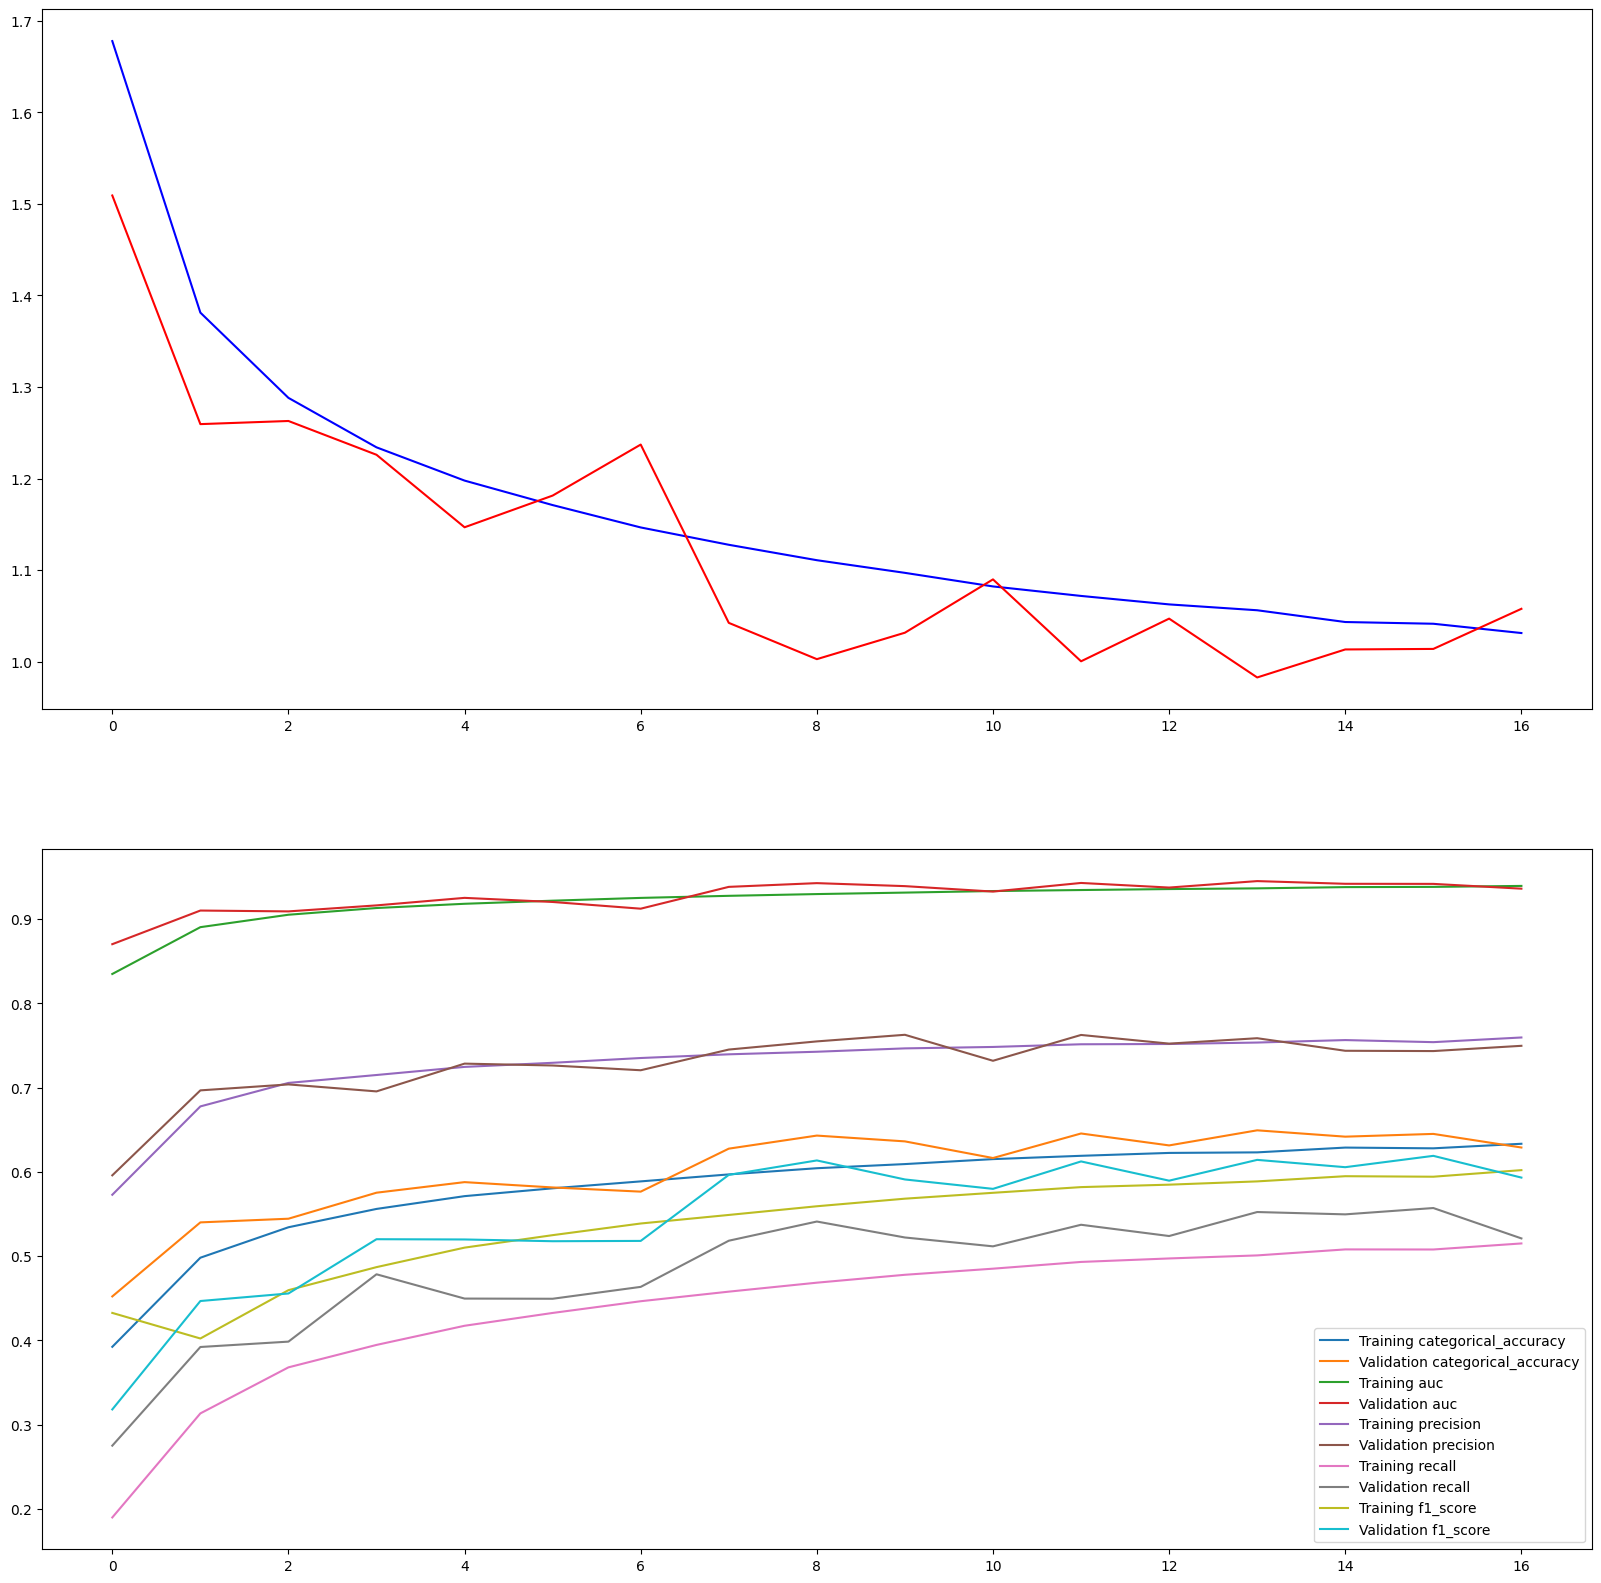

In [98]:
show_training_validation_loss_and_metrics(model13,metrics2)

In [99]:
model13.evaluate(test_it)

5625/5625 [==============================] - 46s 8ms/step - loss: 1.0694 - categorical_accuracy: 0.6268 - auc: 0.9346 - precision: 0.7468 - recall: 0.5229 - f1_score: 0.5947


[1.0694164037704468,
 0.6267666816711426,
 0.9346374273300171,
 0.7467513084411621,
 0.522933304309845,
 0.5946546792984009]

5625/5625 [==============================] - 23s 4ms/step


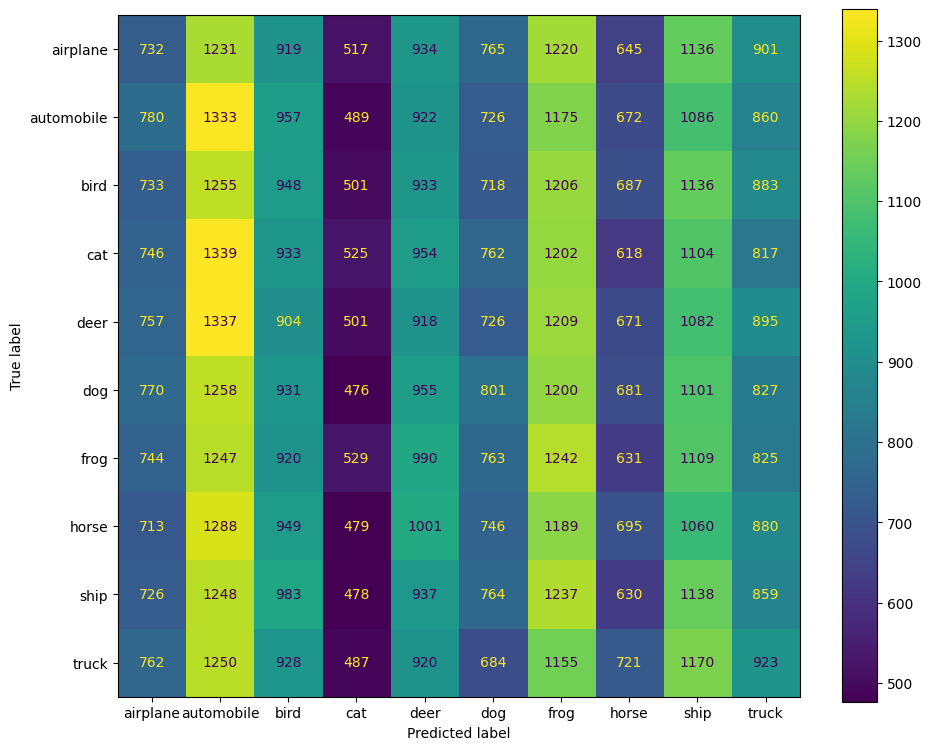

In [100]:
show_confusion_matrix(model13,test_ds,num_classes,class_names)

5625/5625 [==============================] - 23s 4ms/step


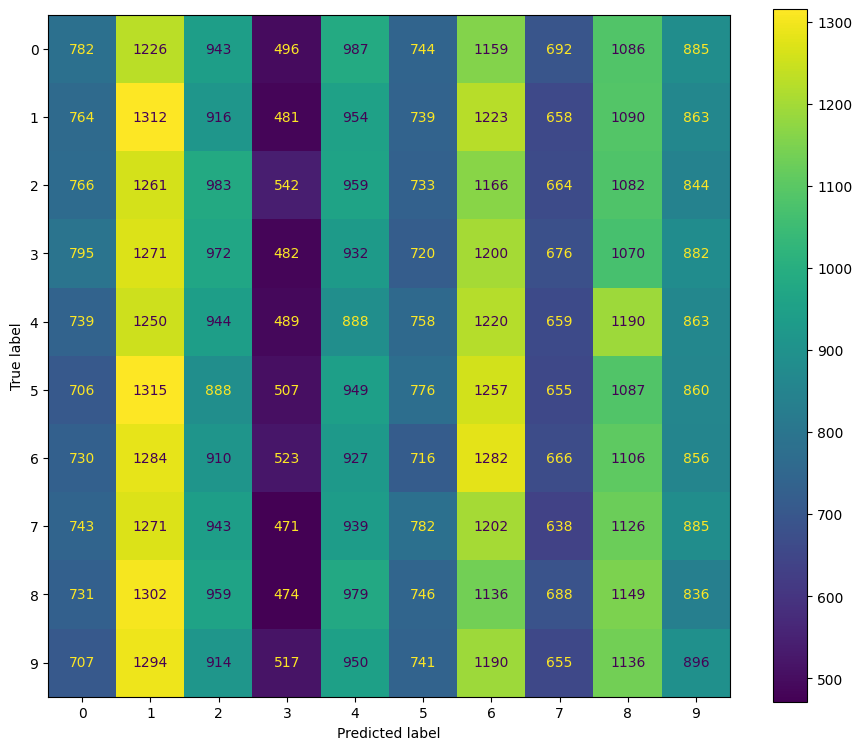

In [101]:
show_confusion_matrix_without_names(model13,test_ds,num_classes)

# Architektura drugiego modelu

In [102]:
model23 = create_model2(num_classes)

In [103]:
model23.compile( 
    loss=loss_func,
    metrics=metrics
)

In [104]:
model23.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_27 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_9 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_28 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                     

In [105]:
history = model23.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 136s 24ms/step - loss: 1.8071 - categorical_accuracy: 0.3392 - auc: 0.8008 - precision: 0.5677 - recall: 0.1033 - f1_score: 0.4177 - val_loss: 1.5194 - val_categorical_accuracy: 0.4398 - val_auc: 0.8657 - val_precision: 0.6474 - val_recall: 0.2261 - val_f1_score: 0.2931
Epoch 2/20
5625/5625 [==============================] - 133s 24ms/step - loss: 1.5329 - categorical_accuracy: 0.4396 - auc: 0.8630 - precision: 0.6514 - recall: 0.2139 - f1_score: 0.2950 - val_loss: 1.4346 - val_categorical_accuracy: 0.4828 - val_auc: 0.8810 - val_precision: 0.6754 - val_recall: 0.2810 - val_f1_score: 0.3580
Epoch 3/20
5625/5625 [==============================] - 133s 24ms/step - loss: 1.4465 - categorical_accuracy: 0.4733 - auc: 0.8790 - precision: 0.6723 - recall: 0.2620 - f1_score: 0.3476 - val_loss: 1.3819 - val_categorical_accuracy: 0.5027 - val_auc: 0.8909 - val_precision: 0.6688 - val_recall: 0.3362 - val_f1_score: 0.4055
Epoch 4/20
5625/562

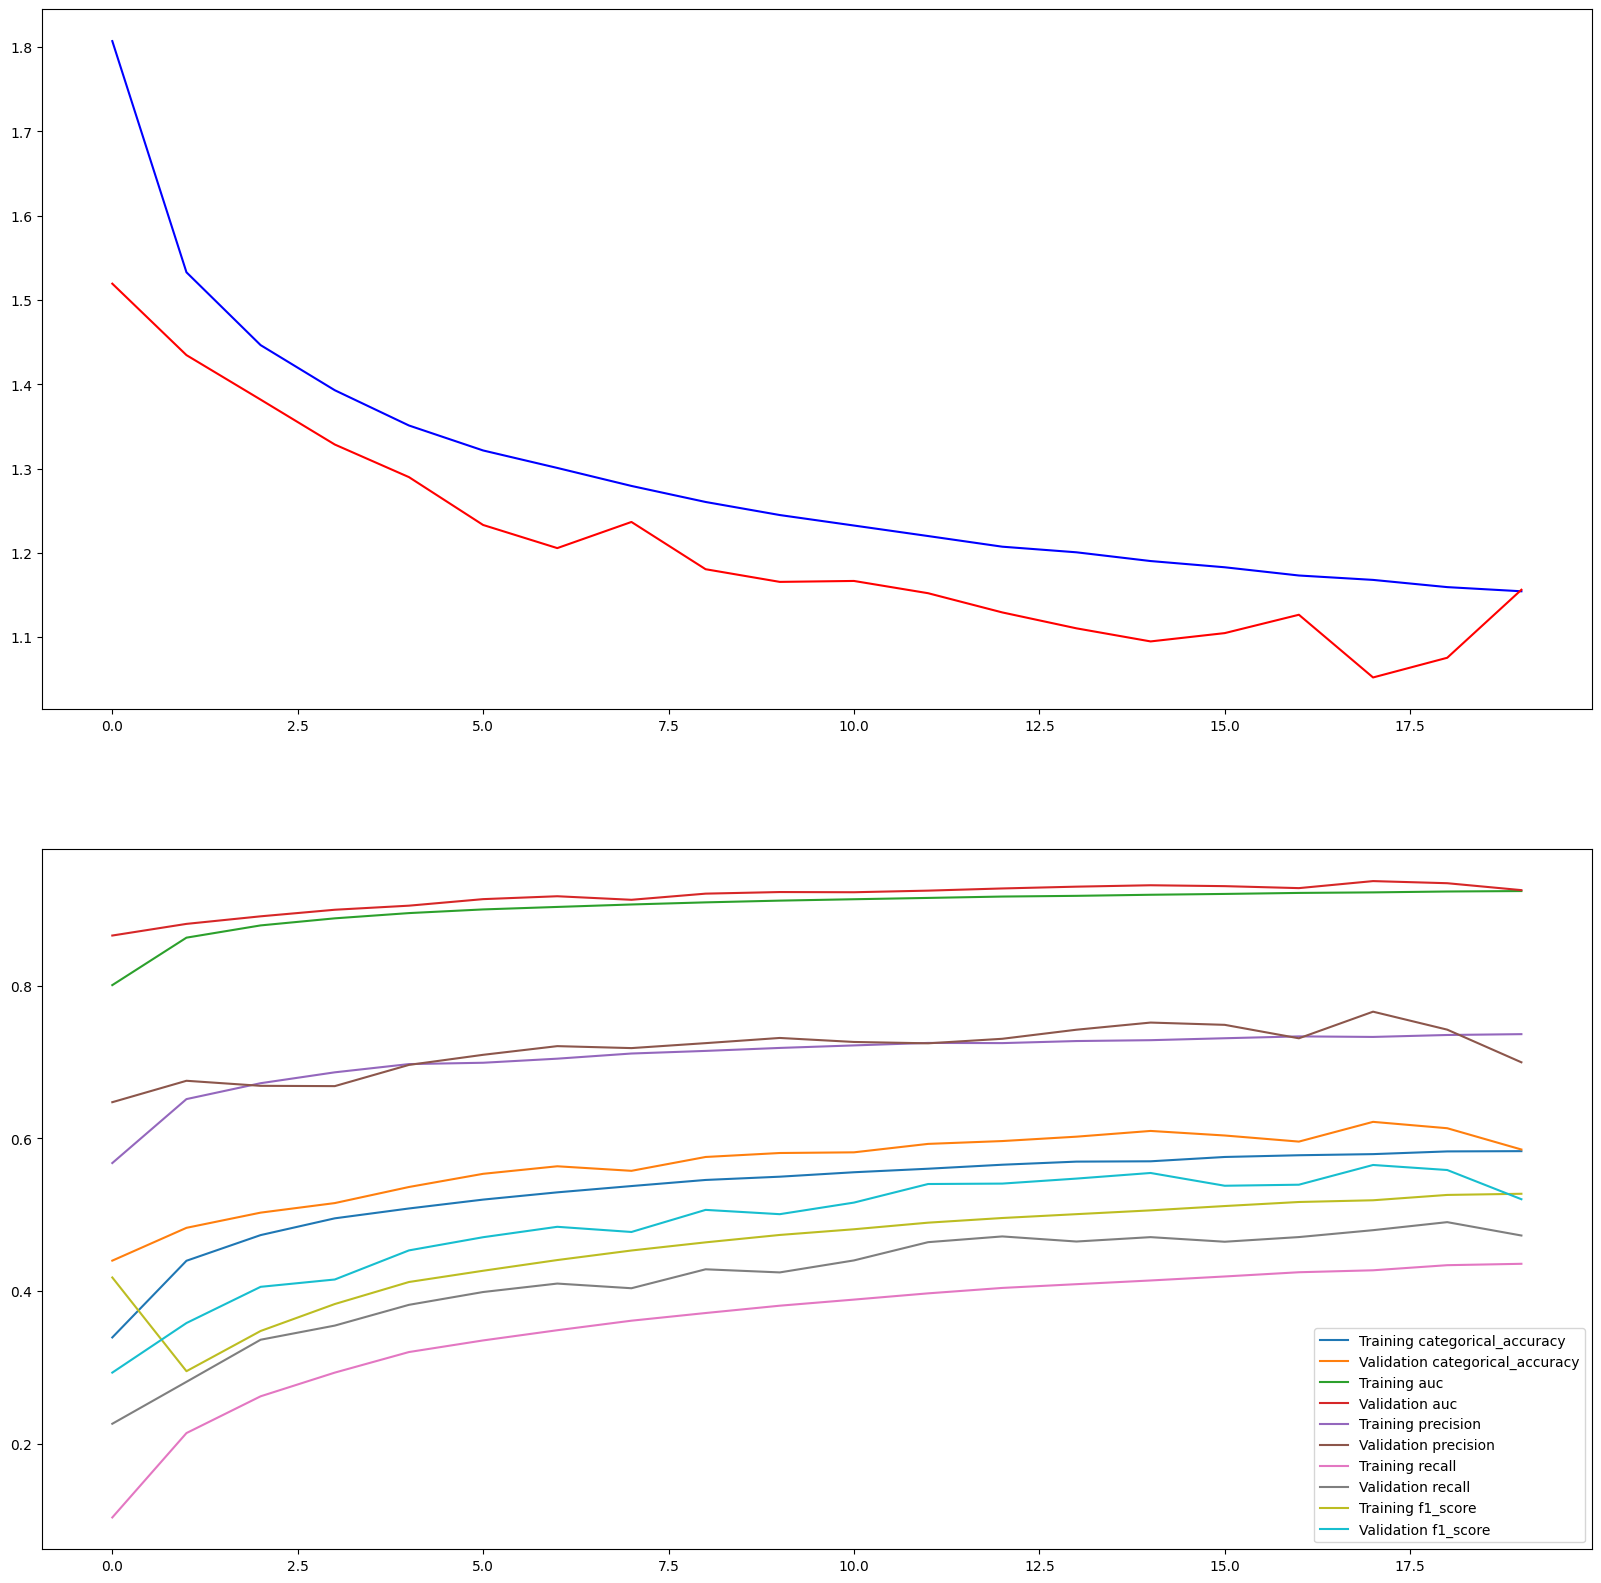

In [106]:
show_training_validation_loss_and_metrics(model23,metrics2)

In [107]:
model23.evaluate(test_it)

5625/5625 [==============================] - 43s 8ms/step - loss: 1.1658 - categorical_accuracy: 0.5846 - auc: 0.9242 - precision: 0.6991 - recall: 0.4711 - f1_score: 0.5191


[1.1657971143722534,
 0.584588885307312,
 0.924197793006897,
 0.6991458535194397,
 0.47110000252723694,
 0.5191183090209961]

5625/5625 [==============================] - 21s 4ms/step


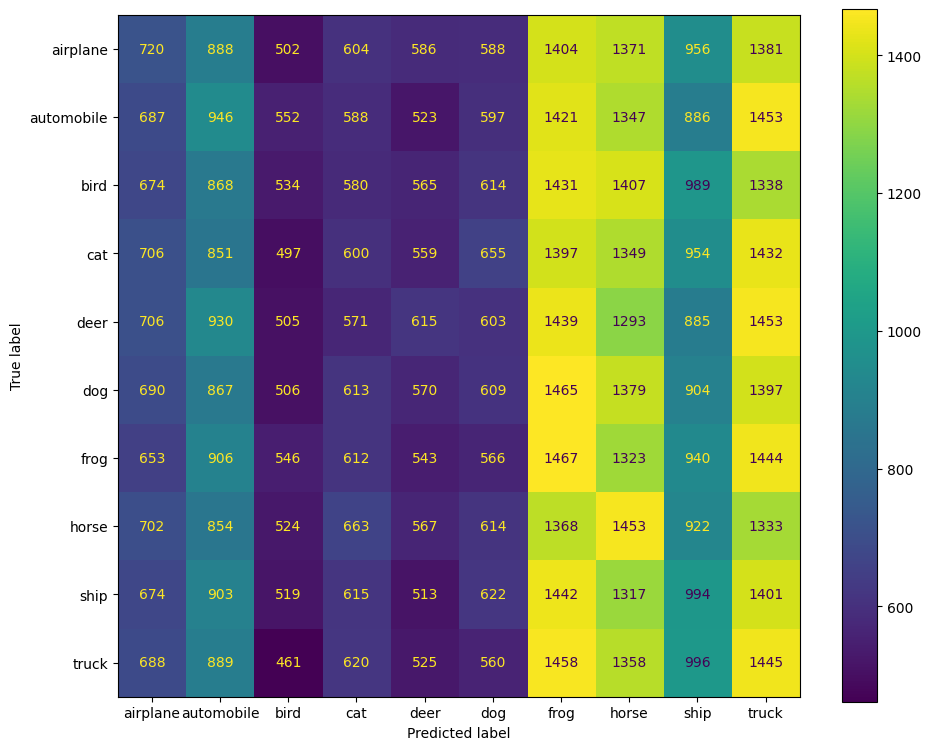

In [108]:
show_confusion_matrix(model23,test_ds,num_classes,class_names)

5625/5625 [==============================] - 21s 4ms/step


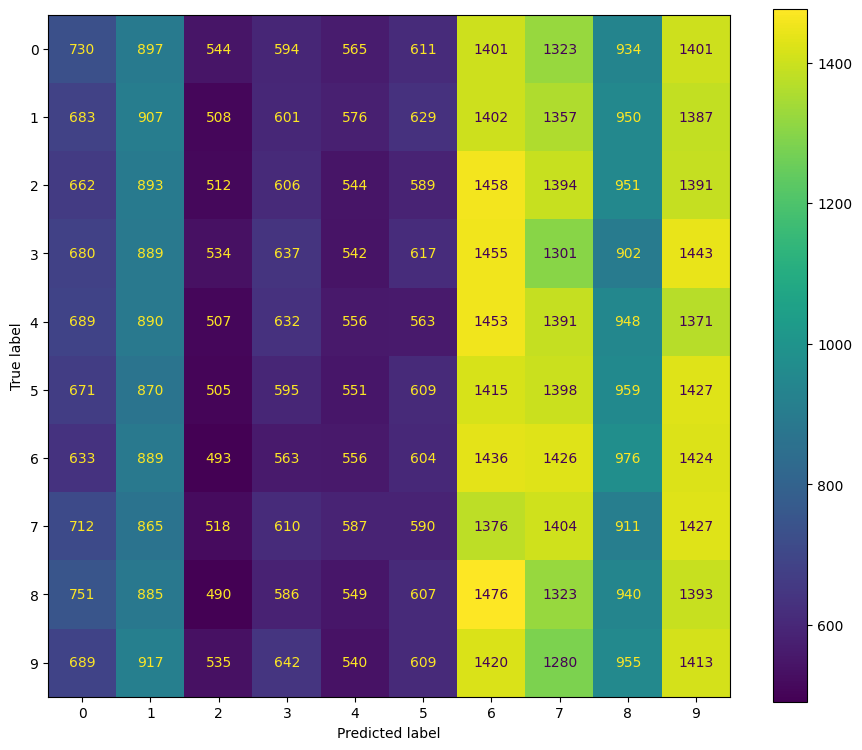

In [109]:
show_confusion_matrix_without_names(model23,test_ds,num_classes)

# Architektura trzeciego modelu

In [110]:
model33 = create_model3(num_classes)

model33.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [111]:
history = model33.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 132s 23ms/step - loss: 1.7522 - categorical_accuracy: 0.3396 - auc: 0.8124 - precision: 0.6044 - recall: 0.0941 - f1_score: 0.3697 - val_loss: 1.5739 - val_categorical_accuracy: 0.4274 - val_auc: 0.8548 - val_precision: 0.6298 - val_recall: 0.2403 - val_f1_score: 0.2912
Epoch 2/20
5625/5625 [==============================] - 130s 23ms/step - loss: 1.5079 - categorical_accuracy: 0.4425 - auc: 0.8677 - precision: 0.6562 - recall: 0.2206 - f1_score: 0.2945 - val_loss: 1.4749 - val_categorical_accuracy: 0.4526 - val_auc: 0.8753 - val_precision: 0.6081 - val_recall: 0.2835 - val_f1_score: 0.3116
Epoch 3/20
5625/5625 [==============================] - 130s 23ms/step - loss: 1.4057 - categorical_accuracy: 0.4841 - auc: 0.8863 - precision: 0.6812 - recall: 0.2802 - f1_score: 0.3600 - val_loss: 1.3781 - val_categorical_accuracy: 0.4997 - val_auc: 0.8922 - val_precision: 0.6461 - val_recall: 0.3480 - val_f1_score: 0.3877
Epoch 4/20
5625/562

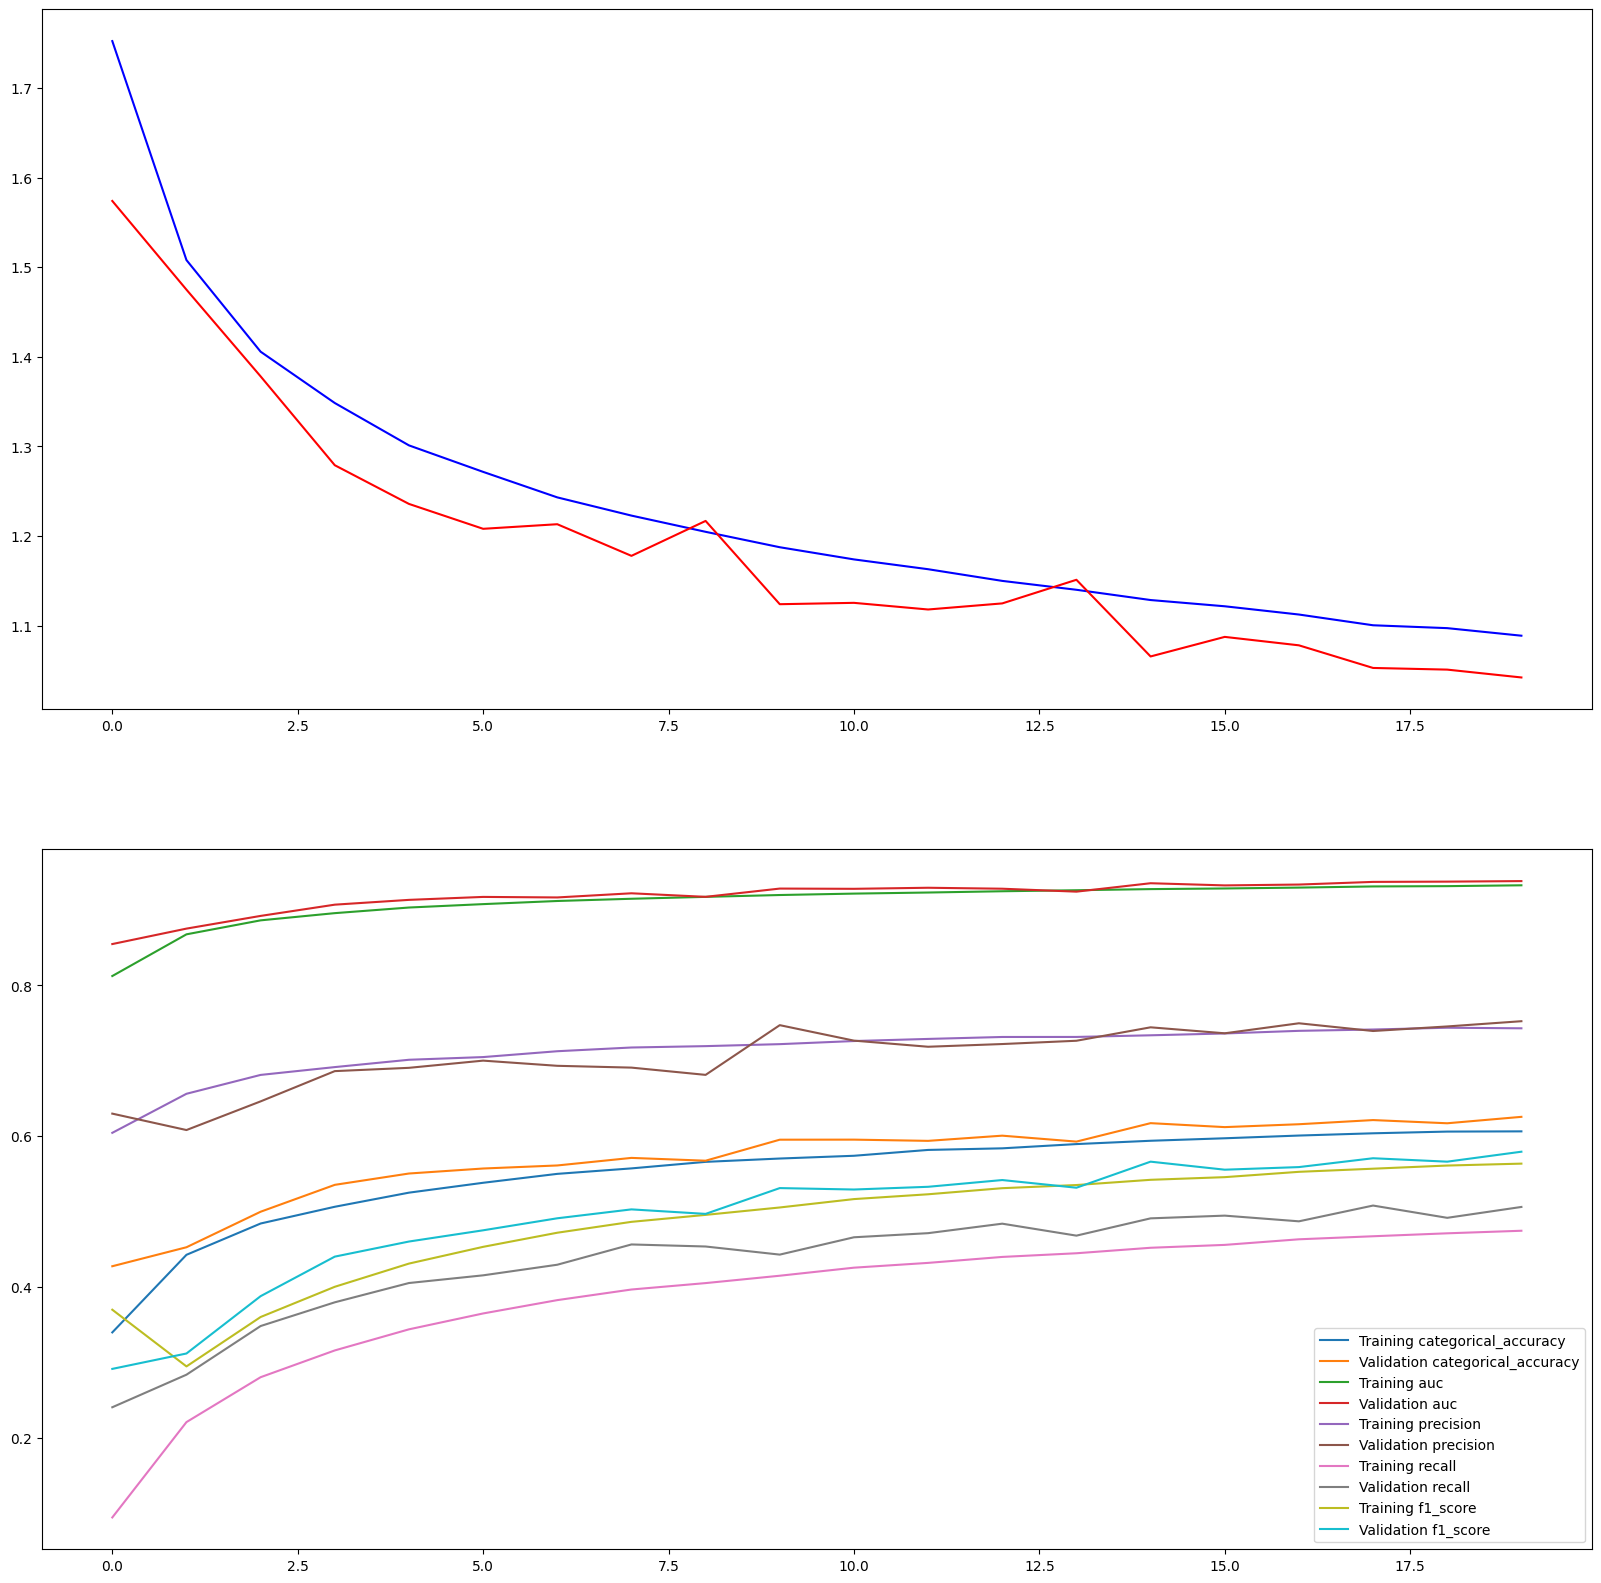

In [112]:
show_training_validation_loss_and_metrics(model33,metrics2)

In [113]:
model33.evaluate(test_it)

5625/5625 [==============================] - 45s 8ms/step - loss: 1.0535 - categorical_accuracy: 0.6218 - auc: 0.9369 - precision: 0.7482 - recall: 0.5023 - f1_score: 0.5761


[1.053460717201233,
 0.621844470500946,
 0.9369338750839233,
 0.7482373714447021,
 0.5023333430290222,
 0.5760607719421387]

5625/5625 [==============================] - 23s 4ms/step


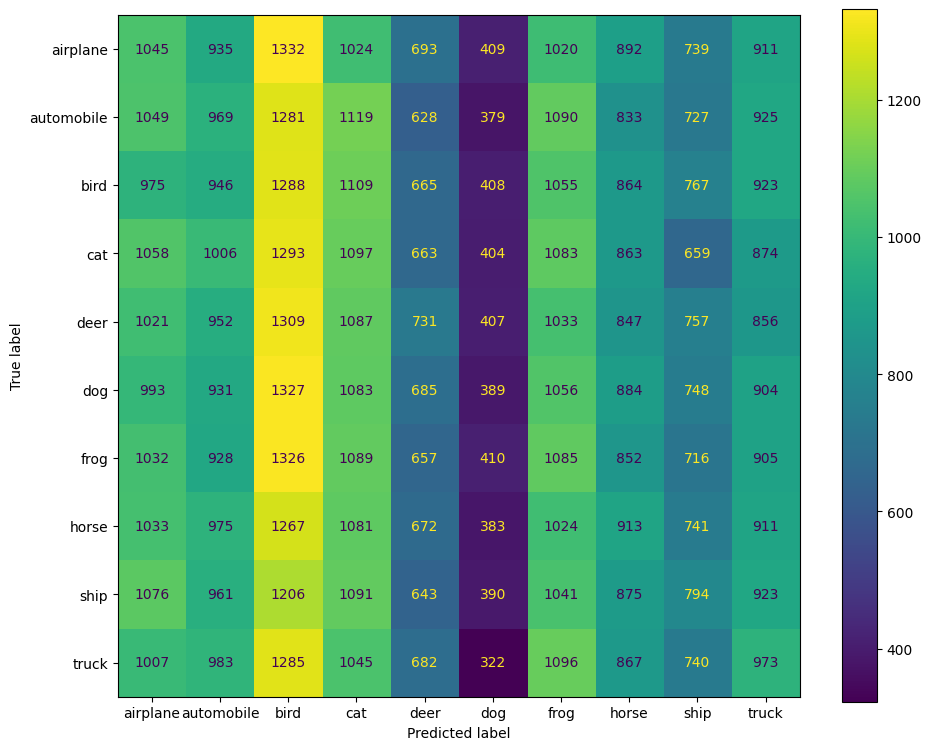

In [114]:
show_confusion_matrix(model33,test_ds,num_classes,class_names)

5625/5625 [==============================] - 22s 4ms/step


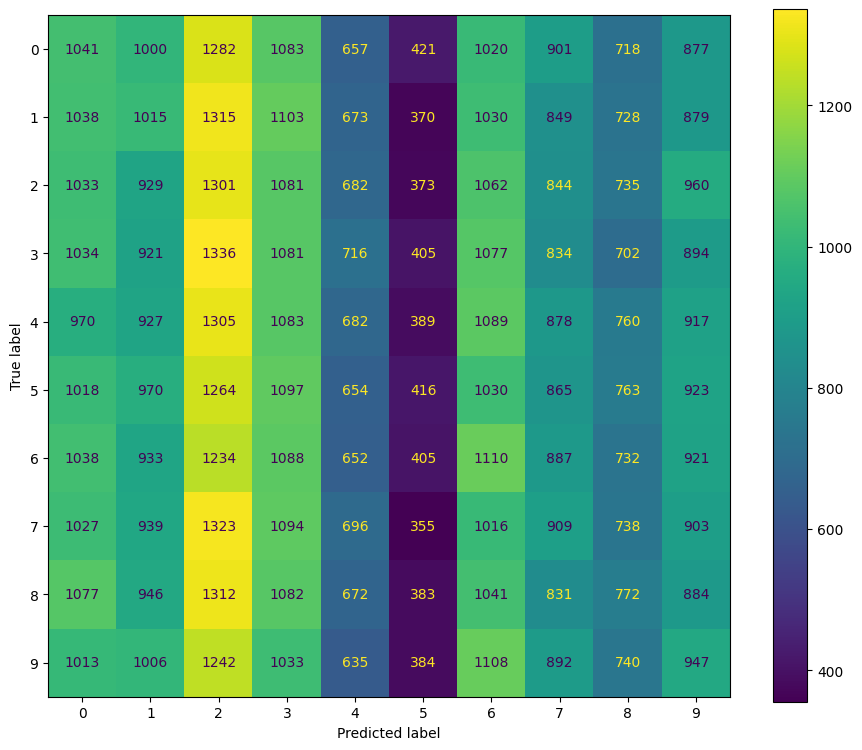

In [115]:
show_confusion_matrix_without_names(model33,test_ds,num_classes)

# Ziarno 313

In [116]:
SEED = 313
tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [117]:
model14 = create_model1(num_classes)

In [118]:
model14.compile( 
    loss=loss_func,
    metrics=metrics
)

In [119]:
model14.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_17 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                     

In [120]:
history = model14.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20


5625/5625 [==============================] - 134s 24ms/step - loss: 1.6762 - categorical_accuracy: 0.3958 - auc: 0.8353 - precision: 0.5771 - recall: 0.1931 - f1_score: 0.4419 - val_loss: 1.5169 - val_categorical_accuracy: 0.4312 - val_auc: 0.8696 - val_precision: 0.5713 - val_recall: 0.2660 - val_f1_score: 0.2932
Epoch 2/20
5625/5625 [==============================] - 139s 25ms/step - loss: 1.3739 - categorical_accuracy: 0.5016 - auc: 0.8916 - precision: 0.6796 - recall: 0.3180 - f1_score: 0.4072 - val_loss: 1.2674 - val_categorical_accuracy: 0.5421 - val_auc: 0.9090 - val_precision: 0.6906 - val_recall: 0.3947 - val_f1_score: 0.4532
Epoch 3/20
5625/5625 [==============================] - 143s 25ms/step - loss: 1.2811 - categorical_accuracy: 0.5381 - auc: 0.9062 - precision: 0.7058 - recall: 0.3702 - f1_score: 0.4628 - val_loss: 1.2466 - val_categorical_accuracy: 0.5506 - val_auc: 0.9120 - val_precision: 0.6917 - val_recall: 0.4103 - val_f1_score: 0.4721
Epoch 4/20
5625/5625 [========

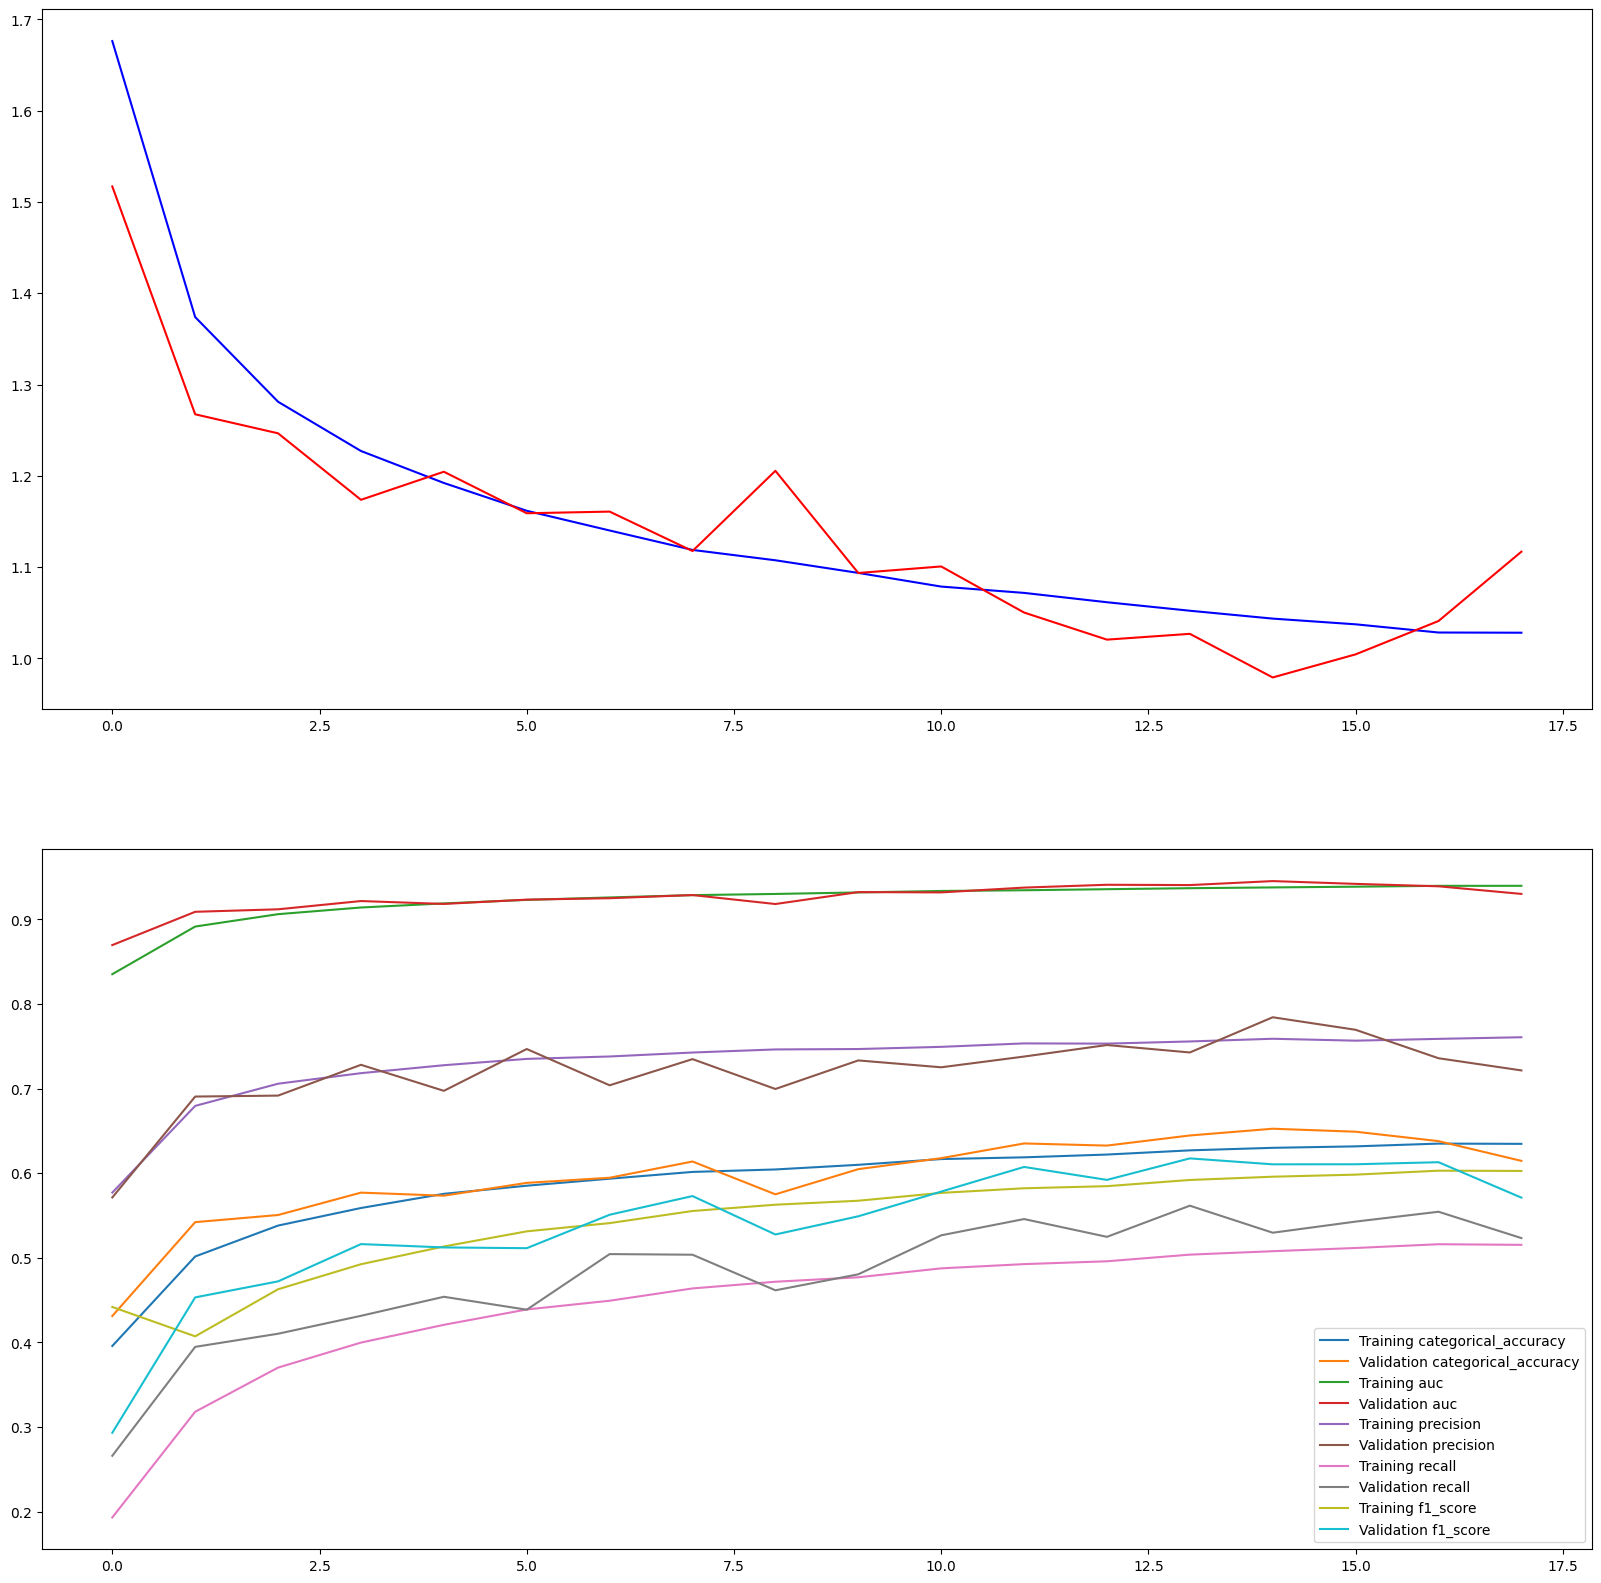

In [121]:
show_training_validation_loss_and_metrics(model14,metrics2)

In [122]:
model14.evaluate(test_it)

   1/5625 [..............................] - ETA: 4:47 - loss: 1.2718 - categorical_accuracy: 0.5000 - auc: 0.9186 - precision: 0.7273 - recall: 0.5000 - f1_score: 0.4940

5625/5625 [==============================] - 46s 8ms/step - loss: 1.1243 - categorical_accuracy: 0.6136 - auc: 0.9292 - precision: 0.7195 - recall: 0.5226 - f1_score: 0.5711


[1.1243492364883423,
 0.6135888695716858,
 0.9292320013046265,
 0.719513475894928,
 0.5225666761398315,
 0.5711055994033813]

5625/5625 [==============================] - 25s 4ms/step


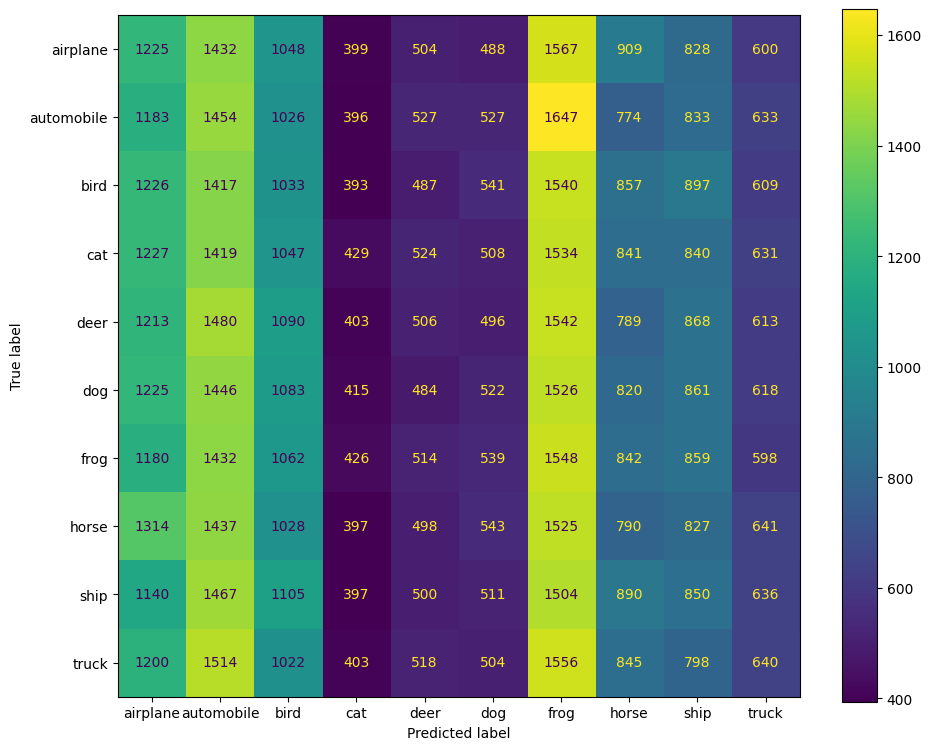

In [123]:
show_confusion_matrix(model14,test_ds,num_classes,class_names)

5625/5625 [==============================] - 25s 4ms/step


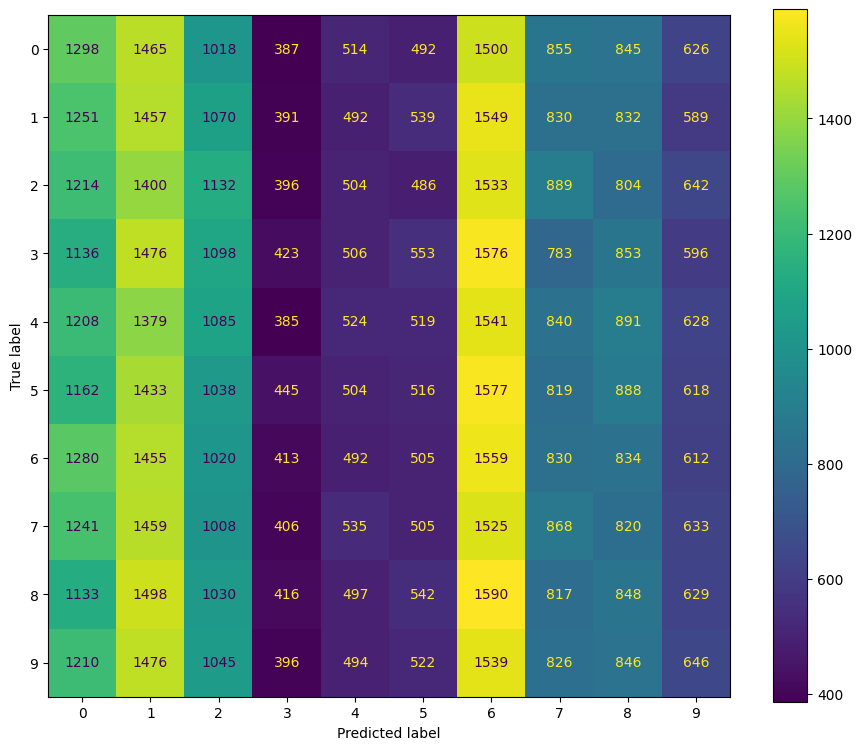

In [124]:
show_confusion_matrix_without_names(model14,test_ds,num_classes)

# Architektura drugiego modelu

In [125]:
model24 = create_model2(num_classes)

In [126]:
model24.compile( 
    loss=loss_func,
    metrics=metrics
)

In [127]:
model24.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_36 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_12 (Avera  (None, 16, 16, 75)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_53 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_37 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                     

In [128]:
history = model24.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 144s 25ms/step - loss: 1.8061 - categorical_accuracy: 0.3403 - auc: 0.8016 - precision: 0.5674 - recall: 0.1028 - f1_score: 0.4047 - val_loss: 1.5033 - val_categorical_accuracy: 0.4448 - val_auc: 0.8689 - val_precision: 0.6546 - val_recall: 0.2220 - val_f1_score: 0.2922
Epoch 2/20
5625/5625 [==============================] - 142s 25ms/step - loss: 1.5330 - categorical_accuracy: 0.4390 - auc: 0.8630 - precision: 0.6540 - recall: 0.2124 - f1_score: 0.2929 - val_loss: 1.4605 - val_categorical_accuracy: 0.4753 - val_auc: 0.8804 - val_precision: 0.6146 - val_recall: 0.3391 - val_f1_score: 0.3738
Epoch 3/20
5625/5625 [==============================] - 143s 25ms/step - loss: 1.4507 - categorical_accuracy: 0.4693 - auc: 0.8783 - precision: 0.6728 - recall: 0.2608 - f1_score: 0.3463 - val_loss: 1.3101 - val_categorical_accuracy: 0.5244 - val_auc: 0.9029 - val_precision: 0.7424 - val_recall: 0.2986 - val_f1_score: 0.3876
Epoch 4/20
5625/562

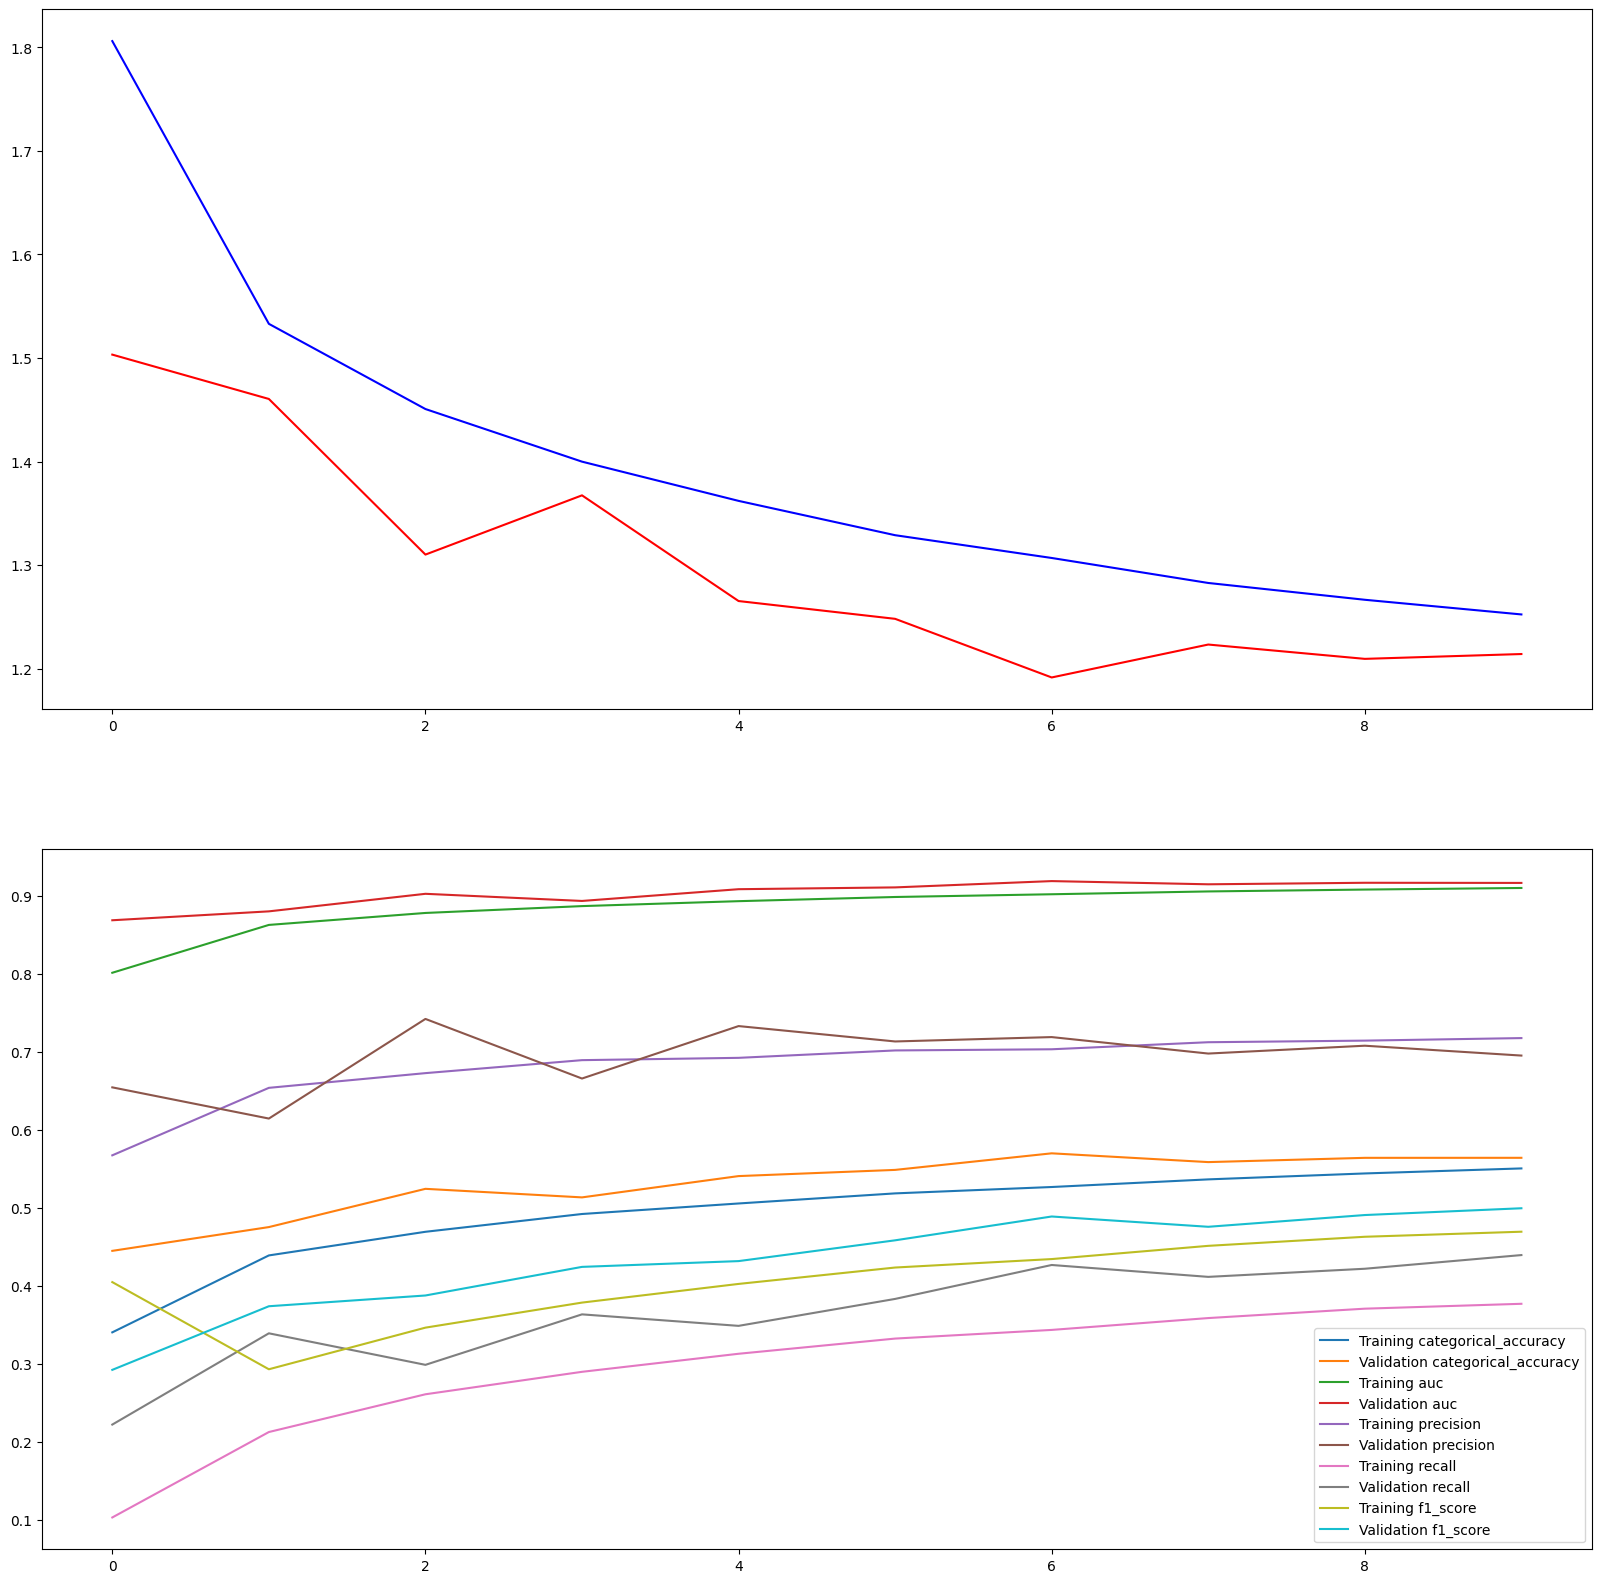

In [129]:
show_training_validation_loss_and_metrics(model24,metrics2)

In [130]:
model24.evaluate(test_it)

5625/5625 [==============================] - 51s 9ms/step - loss: 1.2239 - categorical_accuracy: 0.5621 - auc: 0.9154 - precision: 0.6939 - recall: 0.4392 - f1_score: 0.4985


[1.2239147424697876,
 0.5620777606964111,
 0.9153808355331421,
 0.6939079761505127,
 0.4391666650772095,
 0.49850916862487793]

5625/5625 [==============================] - 22s 4ms/step


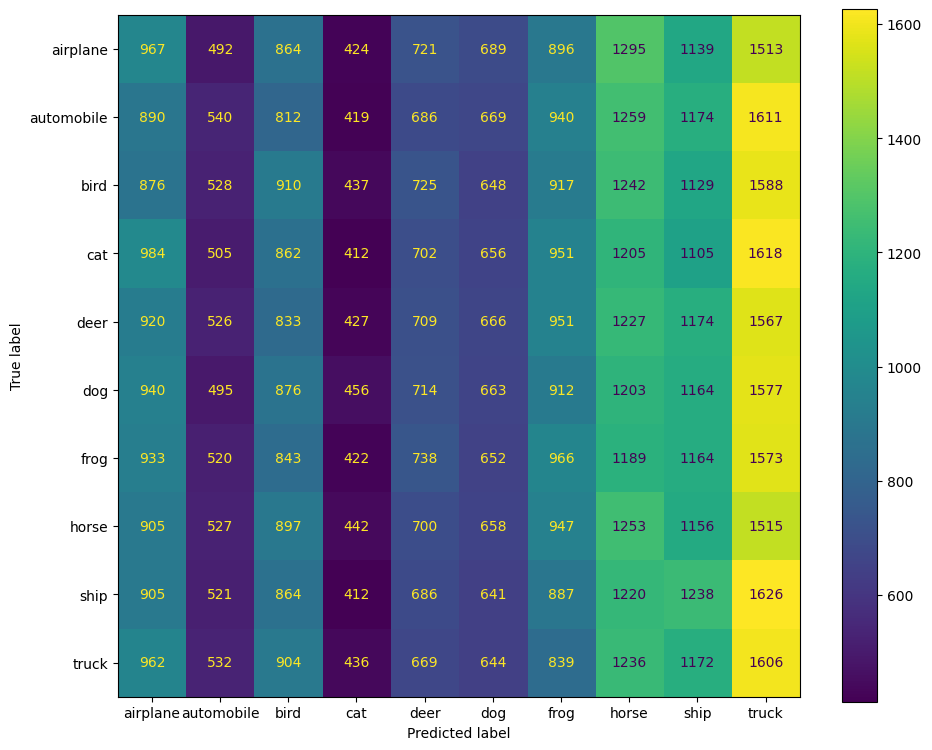

In [131]:
show_confusion_matrix(model24,test_ds,num_classes,class_names)

5625/5625 [==============================] - 22s 4ms/step


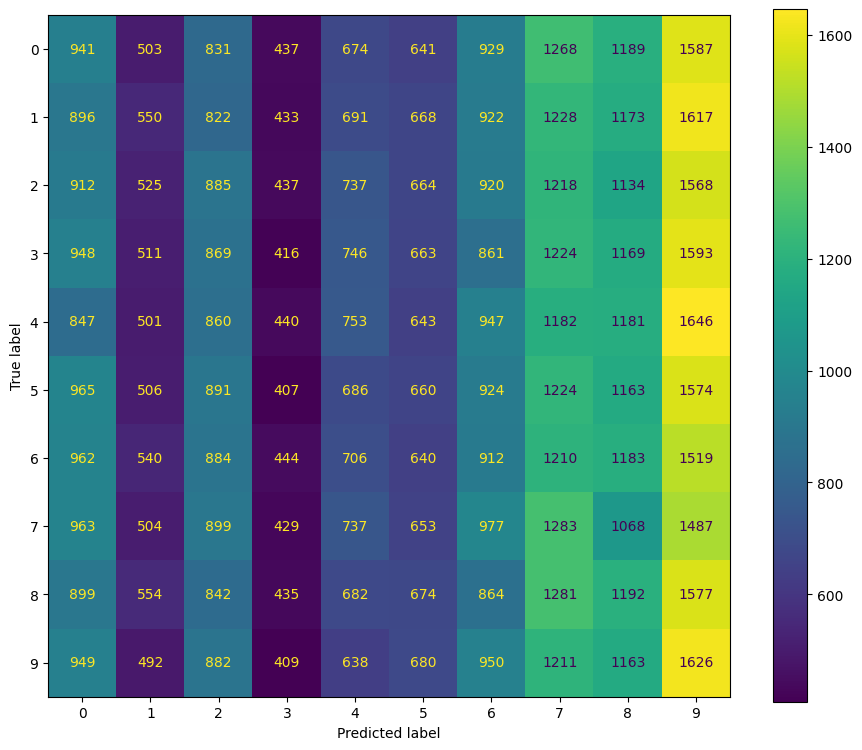

In [132]:
show_confusion_matrix_without_names(model24,test_ds,num_classes)

# Architektura trzeciego modelu

In [133]:
model34 = create_model3(num_classes)

model34.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [134]:
history = model34.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 138s 24ms/step - loss: 1.7449 - categorical_accuracy: 0.3442 - auc: 0.8146 - precision: 0.6027 - recall: 0.0989 - f1_score: 0.3577 - val_loss: 1.5272 - val_categorical_accuracy: 0.4279 - val_auc: 0.8648 - val_precision: 0.6101 - val_recall: 0.2440 - val_f1_score: 0.2926
Epoch 2/20
5625/5625 [==============================] - 135s 24ms/step - loss: 1.5002 - categorical_accuracy: 0.4436 - auc: 0.8692 - precision: 0.6584 - recall: 0.2253 - f1_score: 0.3004 - val_loss: 1.3974 - val_categorical_accuracy: 0.4820 - val_auc: 0.8879 - val_precision: 0.6680 - val_recall: 0.3036 - val_f1_score: 0.3502
Epoch 3/20
5625/5625 [==============================] - 134s 24ms/step - loss: 1.4064 - categorical_accuracy: 0.4818 - auc: 0.8862 - precision: 0.6783 - recall: 0.2780 - f1_score: 0.3571 - val_loss: 1.2915 - val_categorical_accuracy: 0.5234 - val_auc: 0.9051 - val_precision: 0.6828 - val_recall: 0.3596 - val_f1_score: 0.4164
Epoch 4/20
5625/562

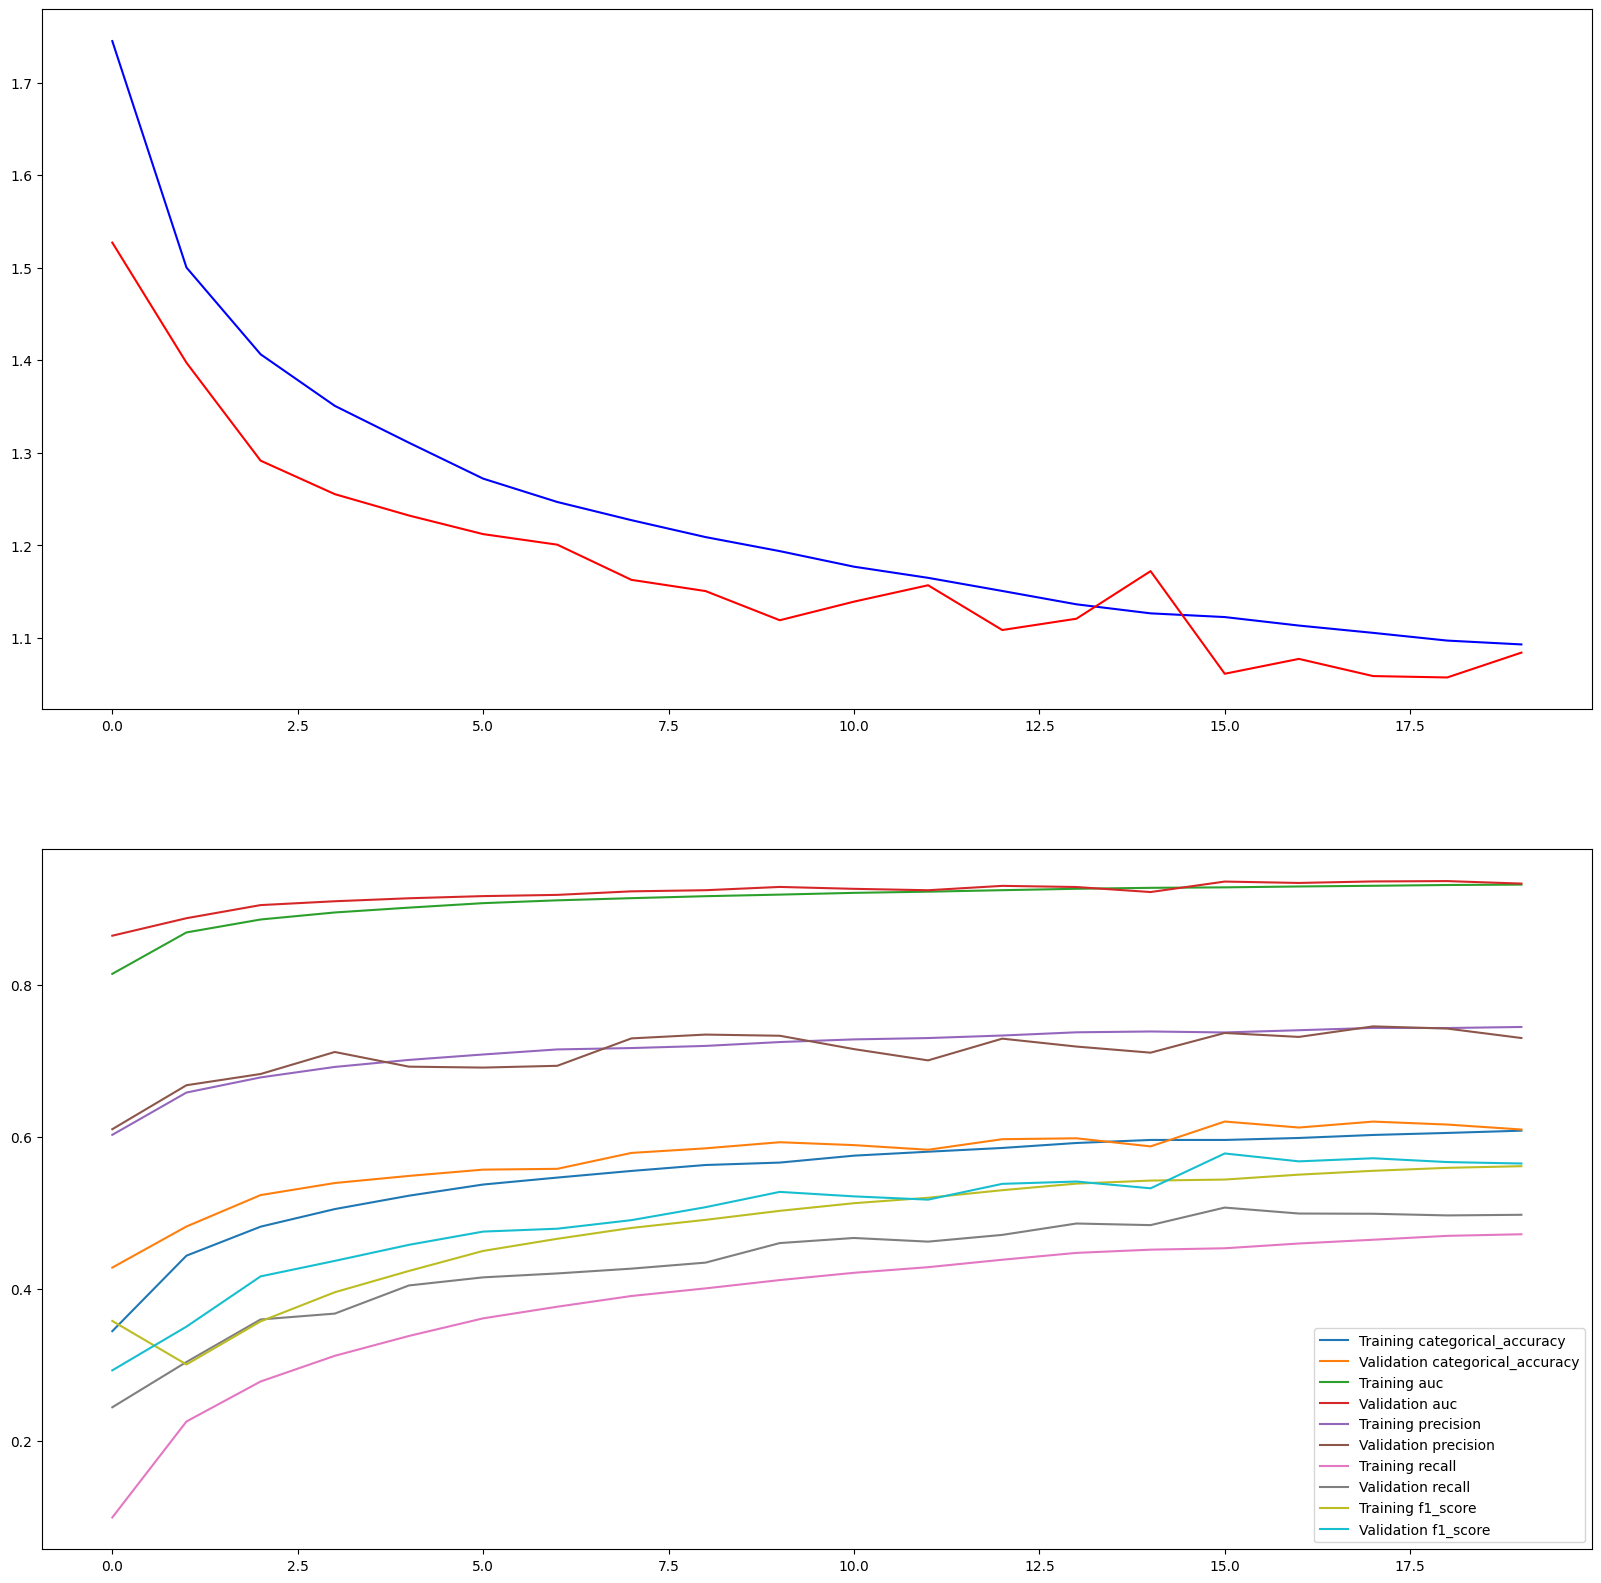

In [135]:
show_training_validation_loss_and_metrics(model34,metrics2)

In [136]:
model34.evaluate(test_it)

5625/5625 [==============================] - 43s 8ms/step - loss: 1.0920 - categorical_accuracy: 0.6091 - auc: 0.9325 - precision: 0.7271 - recall: 0.4973 - f1_score: 0.5641


[1.0920472145080566,
 0.6090666651725769,
 0.9325035214424133,
 0.7271250486373901,
 0.49728888273239136,
 0.5641108155250549]

5625/5625 [==============================] - 22s 4ms/step


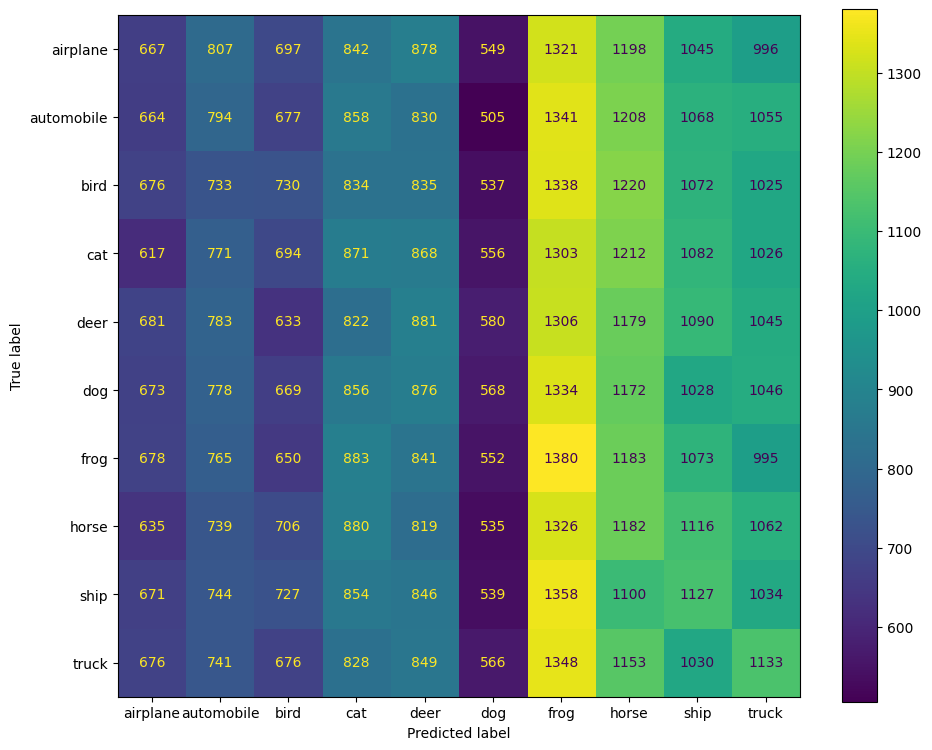

In [137]:
show_confusion_matrix(model34,test_ds,num_classes,class_names)

5625/5625 [==============================] - 23s 4ms/step


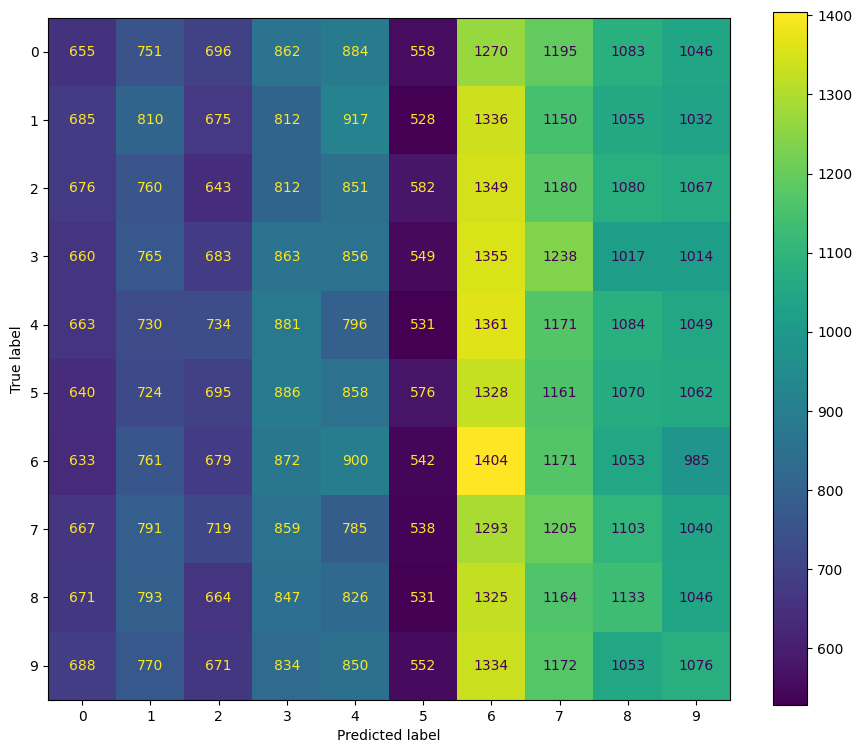

In [138]:
show_confusion_matrix_without_names(model34,test_ds,num_classes)